# Building the Models

## 1. Data Preprocessing

### 1.1. Importing the libraries and dataset

#### 1.1.1. Loading the libraries

In [107]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os

#### 1.1.2. Importing the dataset

In [108]:
# Load dataset 
file_path = '../data/telco_customer_churn.csv' 

# Check if the file exists
if os.path.isfile(file_path):
    dataset_uncleaned = pd.read_csv(file_path)
else:
    raise FileNotFoundError(f"The file was not found at {file_path}")


# Display the first 10 rows 
dataset_uncleaned.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


### 1.2. Cleaning the data

#### 1.2.1. Converting 'TotalCharges' into a numeric column

In [109]:
dataset_uncleaned['TotalCharges'] = pd.to_numeric(dataset_uncleaned['TotalCharges'], errors='coerce')

#### 1.2.2. Dropping rows with NaN (missing) values

In [110]:
dataset = dataset_uncleaned.dropna()

In [111]:
# Check for missing values
print(dataset.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Dataset is now clean.

In [112]:
dataset.shape

(7032, 21)

In [7]:
# numerical = dataset.select_dtypes(include=['number']).columns
# categorical = dataset.select_dtypes(include=['object']).columns

# print("Numerical columns:\n", numerical)
# print("\nCategorical columns:\n", categorical)

### 1.3. Feature Engineering

#### 1.3.1. Reducing redundancy and long labelling for improved readability

In [113]:
# Define columns and values to replace
cols_to_edit = {
    'MultipleLines': 'No phone service',
    ('OnlineSecurity',  'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'): 'No internet service'
}


# Replace "No phone/internet service" with "No"
for key, value in cols_to_edit.items():
    if isinstance(key, tuple):
        for col in key:
            dataset[col] = dataset[col].replace(value, 'No')
    else:
        dataset[key] = dataset[key].replace(value, 'No')


# # Simplify PaymentMethod values
# dataset['PaymentMethod'] = dataset['PaymentMethod'].replace({
#     'Electronic check': 'Automatic',
#     'Mailed check': 'Manual',
#     'Bank transfer (automatic)': 'Automatic',
#     'Credit card (automatic)': 'Automatic',
# })

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/835487539.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[key] = dataset[key].replace(value, 'No')
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/835487539.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[col] = dataset[col].replace(value, 'No')


This simplification could reveal trends like:

- Manual payers being more likely to churn
- Electronic check users being riskier

#### 1.3.2. Addressing Skewness in 'MonthlyCharges' and 'TotalCharges'

Because both are right-skewed, the log1p transformation will be applied. 

In [114]:
dataset['MonthlyCharges_log'] = np.log1p(dataset['MonthlyCharges'])
dataset['TotalCharges_log'] = np.log1p(dataset['TotalCharges'])

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2635752452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['MonthlyCharges_log'] = np.log1p(dataset['MonthlyCharges'])
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2635752452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['TotalCharges_log'] = np.log1p(dataset['TotalCharges'])


If you use tree-based models (DecisionTree, RandomForest, XGBoost, CatBoost) → they don’t care about skewness because they split based on thresholds, not distributions.
If you use linear models (LogisticRegression, etc.) → that’s where log-transforming highly skewed variables helps.

#### 1.3.3. Binning tenure into categories for modelling

In [115]:
bins = [0, 12, 48, 73]
labels = ['Short term', 'Mid term', 'Long term']
dataset['tenure_bin'] = pd.cut(dataset['tenure'], bins=bins, labels=labels, right=False)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2134173997.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['tenure_bin'] = pd.cut(dataset['tenure'], bins=bins, labels=labels, right=False)


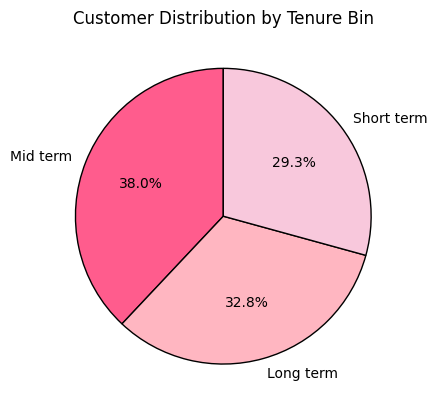

In [116]:
dataset['tenure_bin'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#FF5C8D','#FFB6C1', '#F8C8DC'], wedgeprops={'edgecolor': 'black', 'linewidth': 1}  # adds borders
)

# '#ff69b4', '#ffa500', '#ffb347', '#ffcccb'

plt.title('Customer Distribution by Tenure Bin')
plt.ylabel('')  # Removes y-label
plt.show()

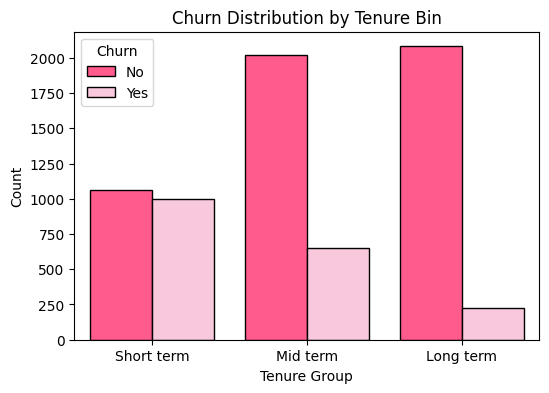

In [117]:
custom_palette = ['#FF5C8D', '#F8C8DC']  # soft pink and peach

plt.figure(figsize=(6,4))
sns.countplot(x='tenure_bin', hue='Churn', data=dataset, palette=custom_palette, edgecolor='black', linewidth=1, saturation=1)

plt.title('Churn Distribution by Tenure Bin')
plt.xlabel('Tenure Group')
plt.ylabel('Count')
plt.show()


##### Notes
Engineered a new bin feature from tenure to make trends more interpretable and sometimes improves tree-based model performance.

"Should I keep the original column as well as the binned column?"

It depends on your goals:

Keep both if:

    You're using a tree-based model (e.g., Random Forest, XGBoost) which handles numeric and categorical features well.

    You want to give the model both raw precision and a more interpretable abstraction.

🧹 Drop the original if:

    You’re using models that don’t handle raw numeric data well or that perform better with simplified inputs (like logistic regression).

    You want to reduce multicollinearity or complexity.

🔁 Recommendation: Try it both ways and evaluate model performance — that’s the best teacher.

#### Binning Monthly Charges

Dividing the tiers into based on prices (fixed ranges) for interpretation and business insight.

- Basic -> $18 - $40 (low spenders, maybe budget-conscious)

- Standard -> $40 - $70 (avergae users, mid-range services)

- Premium -> $70 - $95 (heavier users, possibly multiple services)

- Platinum -> $95 - $120 (top-tier spenders, very engaged customers)


In [118]:
def monthly_plans(plan):
    if plan < 40:
        return 'Basic'
    elif plan < 70:
        return 'Standard'
    elif plan < 95:
        return 'Premium'
    else:
        return 'Platinum'
    
dataset['monthly_pricing_tiers'] = dataset['MonthlyCharges'].apply(monthly_plans)
dataset['monthly_pricing_tiers'].value_counts()

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3662905061.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['monthly_pricing_tiers'] = dataset['MonthlyCharges'].apply(monthly_plans)


monthly_pricing_tiers
Premium     2281
Basic       1831
Standard    1612
Platinum    1308
Name: count, dtype: int64

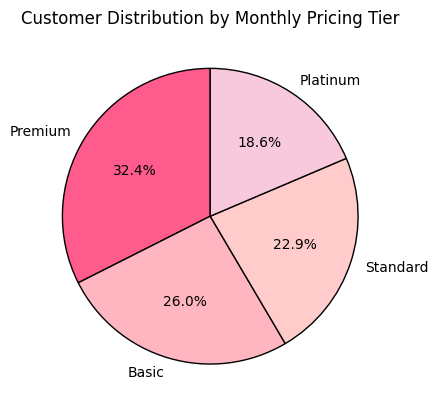

In [119]:
dataset['monthly_pricing_tiers'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['#FF5C8D','#FFB6C1', '#ffcccb', '#F8C8DC'],  # pinks & oranges
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}  # adds borders

)

plt.title('Customer Distribution by Monthly Pricing Tier')
plt.ylabel('')  # hide y-label
plt.show()

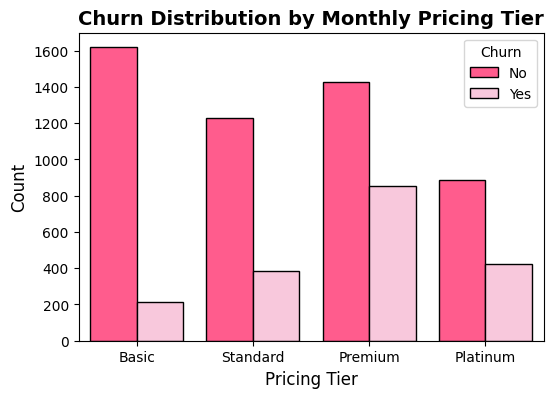

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))

sns.countplot(
    x='monthly_pricing_tiers',
    hue='Churn',
    data=dataset,
    order=['Basic', 'Standard', 'Premium', 'Platinum'],
    palette=['#FF5C8D', '#F8C8DC'],  # custom colors
    edgecolor='black',
    linewidth=1,
    saturation=1  # <-- force full color intensity
)

plt.title('Churn Distribution by Monthly Pricing Tier', fontsize=14, weight='bold')
plt.xlabel('Pricing Tier', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


#### 1.3.5. How far off is the reported TotalCharges from what we’d expect (MonthlyCharges * Tenure)?

- Positive charge_diff → They've paid more than expected (overpaid)
- Negative charge_diff → They've paid less than expected (maybe due to waived fees, discounts, or churn interruptions) (underpaid)

In [121]:
dataset['charge_diff'] = dataset['TotalCharges'] - (dataset['MonthlyCharges'] * dataset['tenure'])
dataset[['charge_diff']]

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2645184554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['charge_diff'] = dataset['TotalCharges'] - (dataset['MonthlyCharges'] * dataset['tenure'])


,charge_diff
0,0.00
1,-46.80
2,0.45
3,-62.75
4,10.25
...,...
7038,-44.70
7039,-67.50
7040,20.85
7041,9.00


Useful because:

- It may highlight billing issues, discounts, or partial months

- Could be a proxy for irregularity in the customer's payment history

### Assessing what discrepancies in charge_diff could mean

- Billing issue: If the difference is large (positive or negative)
Example: If |charge_diff| is greater than 1 month's worth of charges, that's suspicious.

- Discounts: If |charge_diff| is consistently negative but not huge.
Example: A customer has paid less than expected, mybe because of promotions/discounts.

- Partial months: If charge_diff is small (positive or negative), often less than 1 month's charge.
Example: If someone joined mid-month or left mid-month.

In [122]:
'partial_month'
'discount'
'billing_issue'
'ok'

def billing_issue(row):

    charge_diff = row['charge_diff']
    monthly_charge = row['MonthlyCharges']

    # If a c customer joined/left mid-month.
    if abs(charge_diff) < (0.5 * monthly_charge):
        return 'partial_month'
    
    # If a customer consistently paid less
    elif  (-1 * monthly_charge) <= charge_diff <= (-0.5 * monthly_charge):
        return 'discount'
    
    # If something is a billing issue
    elif abs(charge_diff) > monthly_charge:
        return 'billing_issue'
    
    # Perfectly aligned
    elif charge_diff == 0:
        return 'ok'
    
    return 'ok' # default match

# Apply row-wise
dataset['billing_flag'] = dataset.apply(billing_issue, axis = 1)
dataset['billing_flag'].value_counts()

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/1977427616.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['billing_flag'] = dataset.apply(billing_issue, axis = 1)


billing_flag
partial_month    3499
billing_issue    1947
discount          820
ok                766
Name: count, dtype: int64

- partial_month (3,499 customers, ~50%)
    - Very common. Likely customers who joined or left mid-cycle. This makes sense if your dataset has lots of recent joiners or churners.
    - Interpretation: Not necessarily a problem, but shows how many “non-standard” months exist.

- billing_issue (1,947 customers, ~28%)
    - This is large. If your threshold was “absolute difference > 1 month’s charge,” then these are serious mismatches between expected and actual payments.
    - Interpretation: This group is worth investigating — it could be due to data quality issues, unusual billing practices, or misapplied fees.

- discount (820 customers, ~12%)
    - These customers consistently pay less than their expected monthly rate.
    - Interpretation: Could be on promotional offers, loyalty discounts, or bundled packages. Valuable for retention insight (discounted customers may churn less).

- ok (766 customers, ~11%)
    - Everything matches perfectly — “clean” billing.
    - Interpretation: This is your baseline group.

### Billing vs Churn
This tells you whether billing issues, discounts, etc. are related to customer churn.


In [123]:
dataset[['billing_flag', 'Churn']]

cross_tab_billing_flag_with_churn = pd.crosstab(dataset['billing_flag'], dataset['Churn'], normalize='index') * 100
print(cross_tab_billing_flag_with_churn.round(2))
print("-" * 40)

Churn             No    Yes
billing_flag               
billing_issue  86.85  13.15
discount       81.34  18.66
ok             81.98  18.02
partial_month  62.22  37.78
----------------------------------------


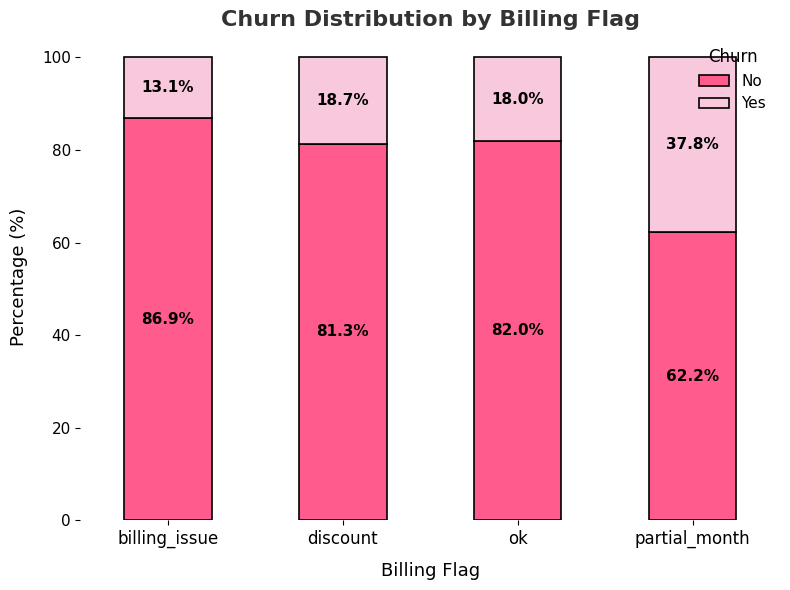

In [124]:
import matplotlib.pyplot as plt

# Crosstab
cross_tab_billing_flag_with_churn = pd.crosstab(
    dataset['billing_flag'], 
    dataset['Churn'], 
    normalize='index'
) * 100

# Custom pink & orange palette
colors = ['#FF5C8D', '#F8C8DC']  # coral pink & soft orange

# Plot
ax = cross_tab_billing_flag_with_churn.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(8, 6),
    edgecolor='black',   # <-- black borders
    linewidth=1.2
)

# Style adjustments
plt.title("Churn Distribution by Billing Flag", fontsize=16, weight='bold', color='#333')
plt.xlabel("Billing Flag", fontsize=13, labelpad=10)
plt.ylabel("Percentage (%)", fontsize=13, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=11)

# Add % labels on each stacked bar
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", color="black", fontsize=11, weight="bold")

# Legend styling
plt.legend(title="Churn", fontsize=11, title_fontsize=12, loc="upper right", frameon=False)

# Remove frame for cleaner look
plt.box(False)

plt.tight_layout()
plt.show()


- Customers flagged as partial_month churn the most by far (≈38%).
    - Likely because they are joining/leaving mid-cycle, so they’re more transient.

- Discount and ok groups have similar churn (~18%).

- Billing issues surprisingly churn less (13%). This could mean:
    - They’re locked into longer contracts (see next table), or
    - Some billing discrepancies aren’t actually frustrating enough to trigger churn.

### Billing vs Contract
This tells you which groups experience the most billing anomalies.

In [125]:
cross_tab_billing_flag_with_contract = pd.crosstab(dataset['billing_flag'], dataset['Contract'], normalize='index') * 100
print(cross_tab_billing_flag_with_contract.round(2))
print("-" * 40)

Contract       Month-to-month  One year  Two year
billing_flag                                     
billing_issue           31.59     28.20     40.22
discount                48.29     23.78     27.93
ok                      48.43     25.46     26.11
partial_month           71.25     15.23     13.52
----------------------------------------


Contract       Month-to-month  One year  Two year
billing_flag                                     
billing_issue           31.59     28.20     40.22
discount                48.29     23.78     27.93
ok                      48.43     25.46     26.11
partial_month           71.25     15.23     13.52
----------------------------------------


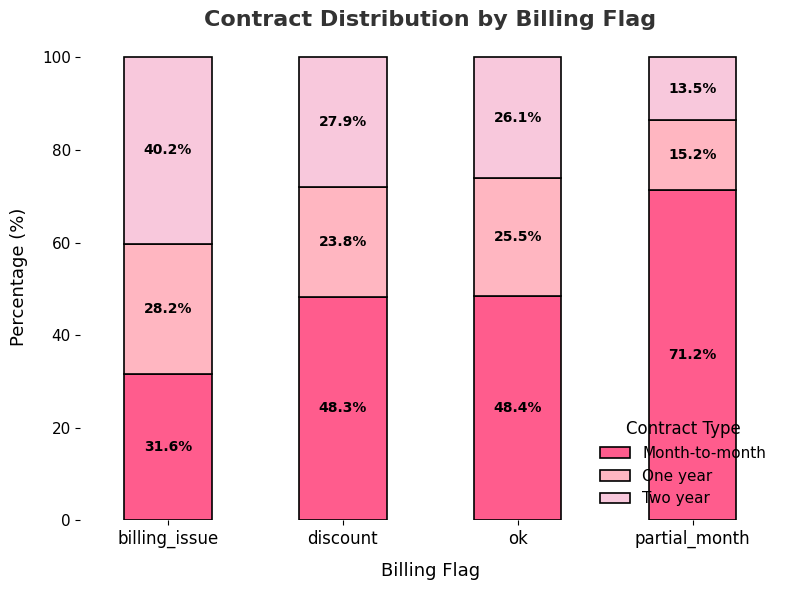

In [126]:
import matplotlib.pyplot as plt

# Crosstab: Billing Flag vs Contract
cross_tab_billing_flag_with_contract = pd.crosstab(
    dataset['billing_flag'], 
    dataset['Contract'], 
    normalize='index'
) * 100

print(cross_tab_billing_flag_with_contract.round(2))
print("-" * 40)

# Custom pink & orange palette
colors = ['#FF5C8D','#FFB6C1', '#F8C8DC']  # pink, soft orange, light pink (for 3 contract types)



# Plot
ax = cross_tab_billing_flag_with_contract.plot(
    kind='bar',
    stacked=True,
    color=colors,
    figsize=(8, 6),
    edgecolor='black',
    linewidth=1.2,
     alpha=1
)

# Style
plt.title("Contract Distribution by Billing Flag", fontsize=16, weight='bold', color='#333')
plt.xlabel("Billing Flag", fontsize=13, labelpad=10)
plt.ylabel("Percentage (%)", fontsize=13, labelpad=10)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=11)

# Add % labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", color="black", fontsize=10, weight="bold")

# Legend styling
plt.legend(title="Contract Type", fontsize=11, title_fontsize=12, loc="lower right", frameon=False)

# Remove frame
plt.box(False)

plt.tight_layout()
plt.show()


- Partial_month overwhelmingly happens in Month-to-month plans (71%).
    - Makes sense: people start/stop often. These are the riskiest churn customers.

- Billing issues are skewed to Two-year contracts (40%).
    - Suggests long-term customers may encounter billing mismatches more often. They don’t churn quickly, but they may become dissatisfied silently.

- Discounts are distributed, but lean toward shorter contracts.

### Billing vs Pricing Tier

In [127]:
cross_tab_billing_flag_with_pricing_tiers = pd.crosstab(dataset['billing_flag'], dataset['monthly_pricing_tiers'], normalize='index') * 100
print(cross_tab_billing_flag_with_pricing_tiers.round(2))
print("-" * 40)

monthly_pricing_tiers  Basic  Platinum  Premium  Standard
billing_flag                                             
billing_issue          38.26     18.90    23.99     18.85
discount               24.27     20.12    34.39     21.22
ok                     21.41     23.37    32.64     22.58
partial_month          20.66     17.03    36.64     25.66
----------------------------------------


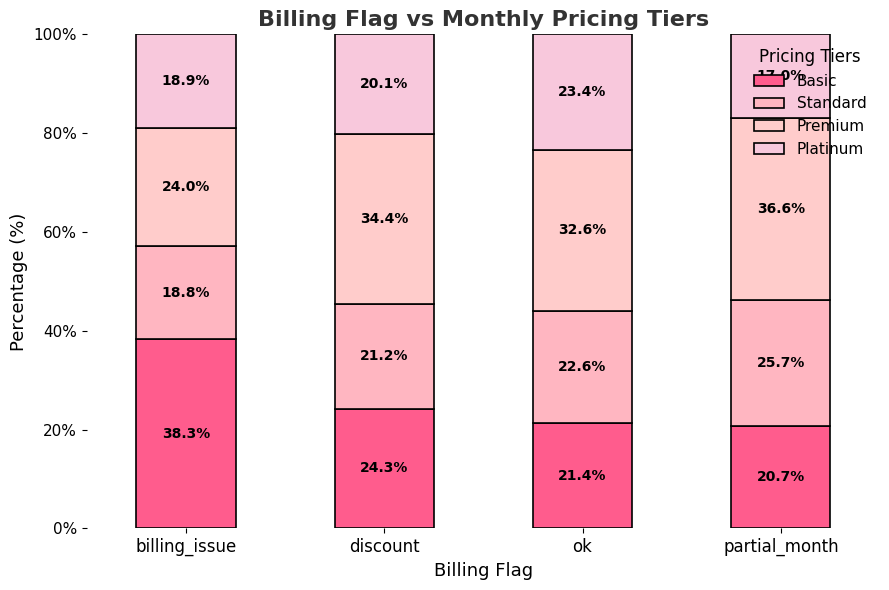

In [128]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


# Plot stacked bar chart
cross_tab_billing_flag_with_pricing_tiers = pd.crosstab(
    dataset['billing_flag'],
    dataset['monthly_pricing_tiers'],
    normalize='index'
) * 100

# (Optional) enforce a nice column order if these tiers exist
order = ['Basic', 'Standard', 'Premium', 'Platinum']
cols = [c for c in order if c in cross_tab_billing_flag_with_pricing_tiers.columns]
ct = cross_tab_billing_flag_with_pricing_tiers[cols] if cols else cross_tab_billing_flag_with_pricing_tiers

# Pink–orange shades (4 tiers)
colors = ['#FF5C8D','#FFB6C1', '#ffcccb', '#F8C8DC']

ax = ct.plot(
    kind='bar',
    stacked=True,
    figsize=(9, 6),
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

# Title/axes
plt.title("Billing Flag vs Monthly Pricing Tiers", fontsize=16, weight='bold', color='#333')
plt.xlabel("Billing Flag", fontsize=13)
plt.ylabel("Percentage (%)", fontsize=13)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=11)
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(PercentFormatter(100))

# Add % labels centered in each stacked segment
for container in ax.containers:
    values = container.datavalues
    labels = [f"{v:.1f}%" if v > 0 else "" for v in values]
    ax.bar_label(container, labels=labels, label_type='center', color='black', fontsize=10, weight='bold')

# Legend and styling
plt.legend(title="Pricing Tiers", fontsize=11, title_fontsize=12, loc="upper right", frameon=False)
plt.box(False)
plt.tight_layout()
plt.show()


- Premium customers show the highest share of discounts (34%).
    - Possible targeted retention strategy: keep high-paying customers happy.

- Billing issues are concentrated in Basic plans (38%).
    - Lower-tier customers may be more sensitive to billing errors.

- Partial month occurs across tiers but highest in Premium (37%).
    - Suggests churn risk is high even among mid-high paying customers.

**<u>Overall Insight</u>**

- Partial-month customers (month-to-month contracts) are the main churn risk group — they’re flexible and leave easily.

- Billing issues affect long-term, Basic plan customers — not an immediate churn trigger, but could harm satisfaction.

- Discounts seem effective, especially for Premium/Platinum tiers, where churn is lower compared to partial-month.

#### Calcutating the average charges per month

In [129]:
dataset['average_charges_per_month'] = (dataset['TotalCharges'] / dataset['tenure']).round(2)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2634961591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['average_charges_per_month'] = (dataset['TotalCharges'] / dataset['tenure']).round(2)


- If low-value customers churn more → they may be more price-sensitive → consider cheaper bundles, discounts, or targeted engagement.

- If high-value customers churn more → business is losing its best customers → signals possible dissatisfaction with service quality or perceived cost vs. benefit.

- If churn is evenly distributed → customer value isn’t the main driver of churn, so other factors (like contract type or support) matter more.

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3362474499.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Churn_encoded'] = dataset['Churn'].map({'No': 0, 'Yes': 1})
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3362474499.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['avg_charge_bin'] = pd.qcut(dataset['average_charges_per_month'], q=5, duplicates='drop')
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3362474499.py:11: FutureWar

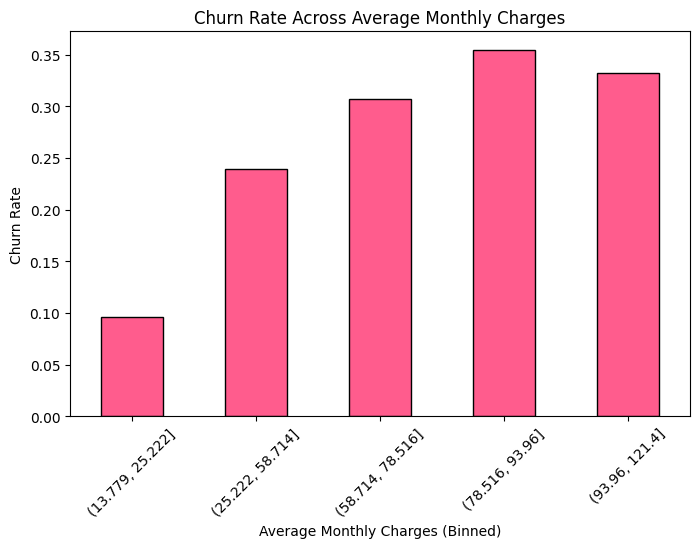

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# # Convert Churn column to numeric if it's still Yes/No
dataset['Churn_encoded'] = dataset['Churn'].map({'No': 0, 'Yes': 1})

# Create bins for average_total_charges
dataset['avg_charge_bin'] = pd.qcut(dataset['average_charges_per_month'], q=5, duplicates='drop')

# Calculate churn rate per bin
churn_rates = dataset.groupby('avg_charge_bin')['Churn_encoded'].mean()

# Plot
plt.figure(figsize=(8,5))
churn_rates.plot(kind='bar', edgecolor='black', color='#FF5C8D')

plt.title('Churn Rate Across Average Monthly Charges')
plt.ylabel('Churn Rate')
plt.xlabel('Average Monthly Charges (Binned)')
plt.xticks(rotation=45)
plt.show()


- Low-paying customers (< $25/month) are more loyal, possibly because they are on basic, affordable plans.

- Mid-to-high paying customers (>$60/month) are much more likely to churn, maybe due to:

Perception of higher cost vs. value
- Competition offering cheaper alternatives
- Extra services not matching expectations

In short: as monthly charges rise, churn risk increases.

#### 1.3.7. Combining 'Contract' & 'Tenure'

What does Contract tell us?
| Contract       | What it means                        |
| -------------- | ------------------------------------ |
| Month-to-month | Can cancel any time (low commitment) |
| One year       | Committed to 12 months               |
| Two year       | Committed to 24 months               |

What does Tenure tell us?
It shows how long they've already been a customer.
1 = just joined
12 = 1 year
36 = 3 years
etc.


What does combining them tell us?
“How long has this person stayed, relative to the contract they signed?”


| Contract       | Tenure | What it might mean              |
| -------------- | ------ | ------------------------------- |
| Month-to-month | 1      | Just joined, no loyalty yet     |
| Month-to-month | 36     | Loyal despite no long contract  |
| One year       | 12     | Finished one year contract      |
| One year       | 24     | Renewed once                    |
| Two year       | 3      | Just started long-term contract |


##### 1.3.7.1. Loyalty flag

In [131]:
dataset['contract_loyalty'] = (
    (dataset['Contract'] != 'Month-to-month') & 
    (dataset['tenure'] > 12)).astype(int)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/342980216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['contract_loyalty'] = (


What it means:
- 1 → Has long contract and stayed over a year → likely loyal
- 0 → Either on month-to-month or hasn’t stayed long

##### 1.3.7.2. Contract Progress

In [133]:
def contract_length(contract):
    if contract == 'Month-to-month':
        return 1
    elif contract == 'One year':
        return 12
    elif contract == 'Two year':
        return 24
    
dataset['contract_length'] = dataset['Contract'].apply(contract_length)
dataset['contract_progress'] = (dataset['tenure'] / dataset['contract_length']).round(2)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2309875274.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['contract_length'] = dataset['Contract'].apply(contract_length)
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2309875274.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['contract_progress'] = (dataset['tenure'] / dataset['contract_length']).round(2)


What it means:
- contract_progress = 1.0 → they finished their contract
- *>1.0 → they renewed
- <1.0 → still within contract

This gives a numeric signal to the model about where the customer is in their commitment journey.

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3758125273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['progress_bin'] = pd.cut(dataset['contract_progress'],
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3758125273.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_dist = dataset.groupby('progress_bin')['Churn'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()


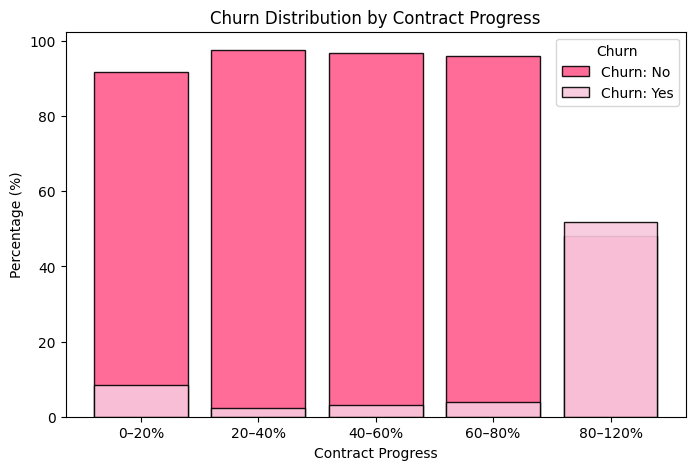

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Bin contract_progress into categories (e.g., 0–20%, 20–40%, etc.)
dataset['progress_bin'] = pd.cut(dataset['contract_progress'], 
                                 bins=[0, 0.2, 0.4, 0.6, 0.8, 1.2], 
                                 labels=['0–20%', '20–40%', '40–60%', '60–80%', '80–120%'])

# Calculate churn distribution per bin
churn_dist = dataset.groupby('progress_bin')['Churn'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()

# Define custom colours for churn = Yes (1) and churn = No (0)
# Define custom colours for churn = Yes / No
colors = {
    "Yes": '#F8C8DC',  # pink for churners
    "No":"#FF5C8D"   # blue for non-churners  nice blue colour "#5C7CFF"
}

# Plot
plt.figure(figsize=(8,5))
for churn_status in churn_dist['Churn'].unique():
    subset = churn_dist[churn_dist['Churn'] == churn_status]
    plt.bar(subset['progress_bin'], subset['percentage'],  
            label=f'Churn: {churn_status}', 
            alpha=0.9,
            color=colors[churn_status], edgecolor='black')  # ✅ works now


plt.title('Churn Distribution by Contract Progress')
plt.ylabel('Percentage (%)')
plt.xlabel('Contract Progress')
plt.legend(title='Churn')
plt.show()


#### Interpretation:
1. Early stages (0–20%):

- Churn rate is higher here (~10%) compared to later stages.

- Suggests that a notable number of customers drop out early into their contracts.

2. Middle stages (20–80%):

- Churn rate is very low (around 2–3%).

- Most customers stick around once they pass the initial onboarding phase.

3. Final stage (80–120%):

- Churn rate jumps up again (~50%).

- Indicates that many customers are leaving as their contracts approach the end or just after the first cycle completes.

In [135]:
dataset['contract_progress'].value_counts()

contract_progress
1.00     642
3.00     553
2.00     271
4.00     193
5.00     152
        ... 
0.12       3
0.38       3
0.04       2
72.00      2
0.21       1
Name: count, Length: 174, dtype: int64

##### Interpretation

dataset['contract_progress'] = (dataset['tenure'] / dataset['contract_length']).round(2)

This gives a number between 0 and 1.
- 0 means the customer just started their contract.
- 1 means the customer has fully completed their contract length.
- Values in between (like 0.25, 0.5, 0.75) mean the customer has completed 25%, 50%, 75% of their contract duration.
- When you bin this into ranges (say [0–0.2], [0.2–0.4], …), the x-axis categories represent “how far along a customer is in their contract”.
    - Example: If the bar at 0.2–0.4 has a churn rate of 0.30, that means 30% of customers who are 20–40% into their contract churned.

This way we can see if:
- customers churn early in the contract?
- they stick until near the end and then churn?
- ofdo renewals (progress >100%) show very low churn?

#### 1.3.8. How many add-ons does a customer subscribes to

In [136]:
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                'TechSupport', 'StreamingTV', 'StreamingMovies']

dataset['ServiceCount'] = (dataset[service_cols] == 'Yes').sum(axis=1)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/1284379579.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ServiceCount'] = (dataset[service_cols] == 'Yes').sum(axis=1)


In [137]:
print(np.sort(dataset['ServiceCount'].unique()))

[0 1 2 3 4 5 6 7 8]


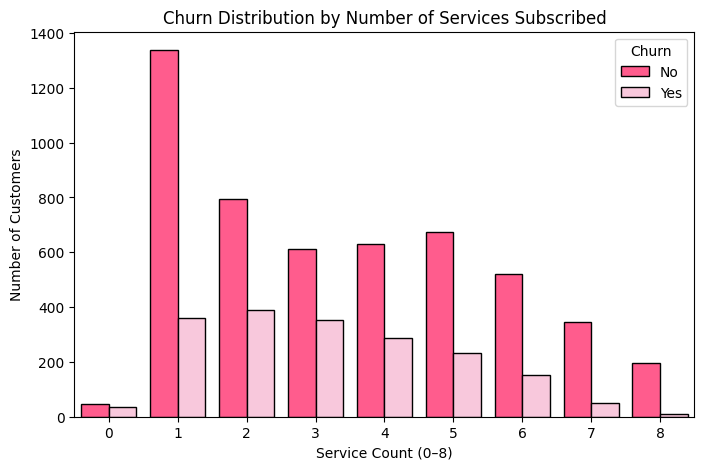

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#FF5C8D', '#F8C8DC'] # coral pink & soft orange


plt.figure(figsize=(8,5))
sns.countplot(data=dataset, x='ServiceCount', hue='Churn', palette=colors, edgecolor='black', saturation=1)
plt.title("Churn Distribution by Number of Services Subscribed")
plt.xlabel("Service Count (0–8)")
plt.ylabel("Number of Customers")
plt.legend(title="Churn")
plt.show()


#### 1.3.9. How expensive was a customers service relative to how long they stuck around?

In [139]:
dataset['charge_tenure_ratio'] = (dataset['MonthlyCharges'] / (dataset['tenure'] + 1)).round(2)
dataset['charge_tenure_ratio_log'] = np.log1p(dataset['charge_tenure_ratio']).round(2)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3202030509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['charge_tenure_ratio'] = (dataset['MonthlyCharges'] / (dataset['tenure'] + 1)).round(2)
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/3202030509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['charge_tenure_ratio_log'] = np.log1p(dataset['charge_tenure_ratio']).round(2)


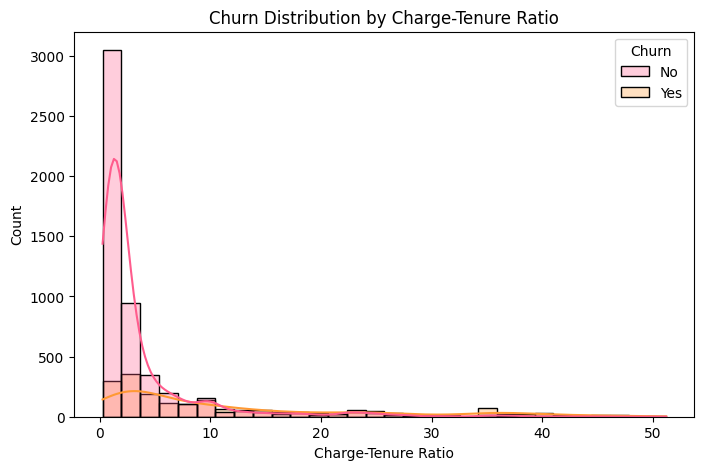

In [140]:
plt.figure(figsize=(8,5))
sns.histplot(data=dataset,
             x='charge_tenure_ratio',
             hue='Churn',
             bins=30,
             kde=True,
             palette={'Yes': '#FF9933', 'No': '#FF5C8D'},
             alpha=0.3)

plt.title("Churn Distribution by Charge-Tenure Ratio")
plt.xlabel("Charge-Tenure Ratio") 
plt.ylabel("Count")
plt.show()

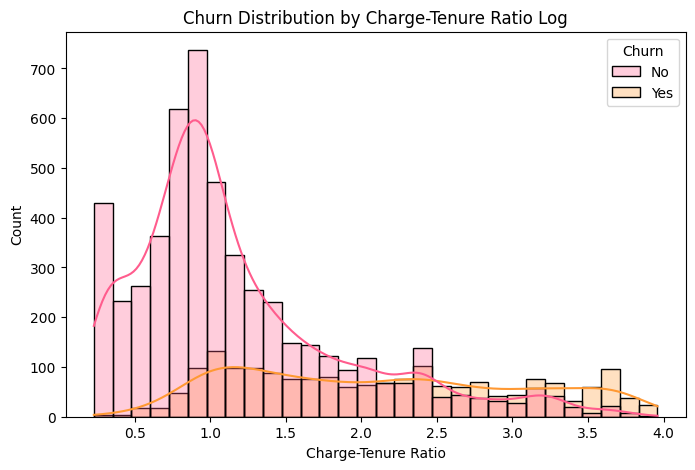

In [141]:
plt.figure(figsize=(8,5))
sns.histplot(data=dataset,
             x='charge_tenure_ratio_log',
             hue='Churn',
             bins=30,
             kde=True,
             palette={'Yes': '#FF9933', 'No': '#FF5C8D'},
             alpha=0.3)

plt.title("Churn Distribution by Charge-Tenure Ratio Log")
plt.xlabel("Charge-Tenure Ratio") 
plt.ylabel("Count")
plt.show()

#### 1.3.10. Could a deeply engaged customer on a longer plan be less likely to leave? (Many Services + One‑year Contract)

- “Deeply engaged” → ServicesCount is high
- “On a longer plan” → Contract is either 'One year' or 'Two year'

What metric is used to decide when a customer is deeply engaged?

In [142]:
dataset['ServiceCount'].value_counts()

ServiceCount
1    1697
2    1186
3     965
4     921
5     906
6     674
7     395
8     208
0      80
Name: count, dtype: int64

In [143]:
dataset['ServiceCount'].describe()

count    7032.000000
mean        3.363339
std         2.062067
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         8.000000
Name: ServiceCount, dtype: float64

Summary of What the Data Says:
- Most common values: 1–3 services
- Median (50%): 3 services
- 75th percentile: 5 services
- Max: 8 services
- Only 25% of customers have more than 5 services
- Only ~21% (1495/7032) have 6 or more


To define deep engagement, it makes sense to pick above-average users, not average ones.
| Threshold | Label                        | % of customers |
| --------- | ---------------------------- | -------------- |
| ≥ 4       | Slightly above median        | \~39%          |
| ≥ 5       | 75th percentile or higher    | \~26%          |
| ≥ 6       | Top quartile (“power users”) | \~21%          |


Captures the top ~25% of customers with many subscribed services → engagement and ustomers on 1-year or 2-year contracts → loyalty


In [144]:
dataset['high_engagement_loyalty'] = (
    (dataset['ServiceCount'] >= 5) & 
    (dataset['contract_length'] >= 12)).astype(int)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2859296723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['high_engagement_loyalty'] = (


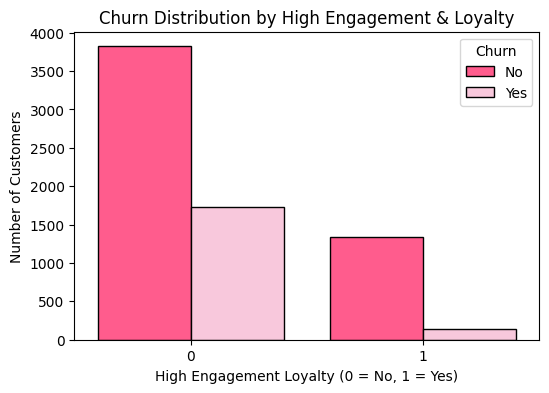

In [145]:
plt.figure(figsize=(6,4))
sns.countplot(data=dataset, x='high_engagement_loyalty', hue='Churn', palette=colors, edgecolor='black', saturation=1)
plt.title("Churn Distribution by High Engagement & Loyalty")
plt.xlabel("High Engagement Loyalty (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.legend(title="Churn")
plt.show()

## NEW FEATURES ENGINEERED RECENTLY

### 1. Service bundle strength

Customers with both phone + internet + streaming may behave differently

In [40]:
dataset["triple_play"] = (
    (dataset["PhoneService"] == "Yes").astype(int) * 
    (dataset["InternetService"] != "No").astype(int) * 
    ((dataset["StreamingTV"] == "Yes") | (dataset["StreamingMovies"] == "Yes")).astype(int)
)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2896537657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["triple_play"] = (


In [41]:
dataset["triple_play"].value_counts()

triple_play
0    3918
1    3114
Name: count, dtype: int64

### Security Engagement
Combine protection - related services

In [42]:
dataset["security_bundle"] = (
    (dataset["OnlineSecurity"] == "Yes").astype(int) + 
    (dataset["OnlineBackup"] == "Yes").astype(int) + 
    (dataset["DeviceProtection"] == "Yes").astype(int) +
    (dataset["TechSupport"] == "Yes").astype(int)
)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2896558571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["security_bundle"] = (


In [43]:
dataset["security_bundle"].value_counts()

security_bundle
0    2787
1    1467
2    1372
3     937
4     469
Name: count, dtype: int64

### Contract × Paperless Billing interaction

Some customers with month-to-month + paperless churn faster.

In [44]:
dataset["contract_paperless"] = dataset["Contract"].astype(str) + "_" + dataset["PaperlessBilling"].astype(str)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/4098560123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["contract_paperless"] = dataset["Contract"].astype(str) + "_" + dataset["PaperlessBilling"].astype(str)


In [45]:
dataset["contract_paperless"].value_counts()

contract_paperless
Month-to-month_Yes    2586
Month-to-month_No     1289
Two year_No            902
One year_Yes           799
Two year_Yes           783
One year_No            673
Name: count, dtype: int64

In [46]:
dataset["contract_paperless"].nunique()

6

### 4. High spend per service ratio

You already have charge_tenure_ratio, but we can normalize spend by number of services:

In [47]:
dataset["spend_per_service"] = dataset["MonthlyCharges_log"] / (dataset["ServiceCount"].replace(0, 1))

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2961609126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["spend_per_service"] = dataset["MonthlyCharges_log"] / (dataset["ServiceCount"].replace(0, 1))


In [48]:
dataset["spend_per_service"].value_counts()

spend_per_service
3.046901    61
3.039749    44
3.037354    44
3.042139    44
3.027715    43
            ..
0.592299     1
0.836563     1
1.012075     1
0.759330     1
3.587677     1
Name: count, Length: 2698, dtype: int64

In [49]:
dataset["spend_per_service"].nunique()

2698

### Senior + Contract length

Older customers may behave differently with long vs. short contracts.

In [50]:
dataset["senior_contract"] = dataset["SeniorCitizen"] * dataset["contract_length"]

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/1954367056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["senior_contract"] = dataset["SeniorCitizen"] * dataset["contract_length"]


In [51]:
dataset["senior_contract"].value_counts()

senior_contract
0     5890
1      807
12     190
24     145
Name: count, dtype: int64

### 7. Streaming bundle

For internet customers, streaming may be sticky — or indicate high-risk add-ons.

In [52]:
dataset["streaming_bundle"] = (
    (dataset["StreamingTV"] == "Yes").astype(int) +
    (dataset["StreamingMovies"] == "Yes").astype(int)
)

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2749737405.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["streaming_bundle"] = (


In [53]:
dataset["streaming_bundle"].value_counts()

streaming_bundle
0    3537
2    1939
1    1556
Name: count, dtype: int64

In [146]:
dataset.shape

(7032, 38)

In [147]:
dataset.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Churn_encoded,avg_charge_bin,contract_loyalty,contract_length,contract_progress,progress_bin,ServiceCount,charge_tenure_ratio,charge_tenure_ratio_log,high_engagement_loyalty
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,0,"(25.222, 58.714]",0,1,1.00,80–120%,1,14.92,2.77,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,0,"(25.222, 58.714]",1,12,2.83,NaN,3,1.63,0.97,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,1,"(25.222, 58.714]",0,1,2.00,NaN,3,17.95,2.94,0
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,0,"(25.222, 58.714]",1,12,3.75,NaN,3,0.92,0.65,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,1,"(58.714, 78.516]",0,1,2.00,NaN,1,23.57,3.20,0
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,1,"(93.96, 121.4]",0,1,8.00,NaN,5,11.07,2.49,0
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,0,"(78.516, 93.96]",0,1,22.00,NaN,4,3.87,1.58,0
7,6713-OKOMC,Female,0,No,No,10,No,No,DSL,Yes,...,0,"(25.222, 58.714]",0,1,10.00,NaN,1,2.70,1.31,0
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,1,"(93.96, 121.4]",0,1,28.00,NaN,6,3.61,1.53,0
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,0,"(25.222, 58.714]",1,12,5.17,NaN,3,0.89,0.64,0


In [148]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7032 non-null   object  
 1   gender                     7032 non-null   object  
 2   SeniorCitizen              7032 non-null   int64   
 3   Partner                    7032 non-null   object  
 4   Dependents                 7032 non-null   object  
 5   tenure                     7032 non-null   int64   
 6   PhoneService               7032 non-null   object  
 7   MultipleLines              7032 non-null   object  
 8   InternetService            7032 non-null   object  
 9   OnlineSecurity             7032 non-null   object  
 10  OnlineBackup               7032 non-null   object  
 11  DeviceProtection           7032 non-null   object  
 12  TechSupport                7032 non-null   object  
 13  StreamingTV                7032 non-nu

In [149]:
dataset.nunique()

customerID                   7032
gender                          2
SeniorCitizen                   2
Partner                         2
Dependents                      2
tenure                         72
PhoneService                    2
MultipleLines                   2
InternetService                 3
OnlineSecurity                  2
OnlineBackup                    2
DeviceProtection                2
TechSupport                     2
StreamingTV                     2
StreamingMovies                 2
Contract                        3
PaperlessBilling                2
PaymentMethod                   4
MonthlyCharges               1584
TotalCharges                 6530
Churn                           2
MonthlyCharges_log           1584
TotalCharges_log             6530
tenure_bin                      3
monthly_pricing_tiers           4
charge_diff                  5310
billing_flag                    4
average_charges_per_month    4577
Churn_encoded                   2
avg_charge_bin

### Dropping Features That Are No Longer Needed

In [150]:
features_to_remove = ['customerID', 'MonthlyCharges', 'TotalCharges', 
                      'avg_charge_bin', 'charge_diff', 'charge_tenure_ratio', 
                      'contract_length', 'Churn', 'Churn_encoded', 'progress_bin']

#### 1.3.11. Defining the matrix of features

In [151]:
# Defining the matrix of features
X_untransformed = dataset.drop(columns=features_to_remove, axis=1)


feature_names = X_untransformed.columns.tolist()


# X_untransformed = dataset.iloc[:, 1:-1].copy()
print(type(X_untransformed))

print("\n")

X_untransformed.head(10)

<class 'pandas.core.frame.DataFrame'>




,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TotalCharges_log,tenure_bin,monthly_pricing_tiers,billing_flag,average_charges_per_month,contract_loyalty,contract_progress,ServiceCount,charge_tenure_ratio_log,high_engagement_loyalty
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,...,3.429137,Short term,Basic,partial_month,29.85,0,1.00,1,2.77,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,7.544597,Mid term,Standard,discount,55.57,1,2.83,3,0.97,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,4.692723,Short term,Standard,partial_month,54.08,0,2.00,3,2.94,0
3,Male,0,No,No,45,No,No,DSL,Yes,No,...,7.518471,Mid term,Standard,billing_issue,40.91,1,3.75,3,0.65,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,5.028148,Short term,Premium,partial_month,75.82,0,2.00,1,3.20,0
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,...,6.711132,Short term,Platinum,partial_month,102.56,0,8.00,5,2.49,0
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,...,7.575790,Mid term,Premium,partial_month,88.61,0,22.00,4,1.58,0
7,Female,0,No,No,10,No,No,DSL,Yes,No,...,5.713403,Short term,Basic,partial_month,30.19,0,10.00,1,1.31,0
8,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,...,8.021929,Mid term,Platinum,billing_issue,108.79,0,28.00,6,1.53,0
9,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,...,8.157356,Long term,Standard,partial_month,56.26,1,5.17,3,0.64,0


In [152]:
X_untransformed.shape

(7032, 28)

In [153]:
X_untransformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     7032 non-null   object  
 1   SeniorCitizen              7032 non-null   int64   
 2   Partner                    7032 non-null   object  
 3   Dependents                 7032 non-null   object  
 4   tenure                     7032 non-null   int64   
 5   PhoneService               7032 non-null   object  
 6   MultipleLines              7032 non-null   object  
 7   InternetService            7032 non-null   object  
 8   OnlineSecurity             7032 non-null   object  
 9   OnlineBackup               7032 non-null   object  
 10  DeviceProtection           7032 non-null   object  
 11  TechSupport                7032 non-null   object  
 12  StreamingTV                7032 non-null   object  
 13  StreamingMovies            7032 non-nu

In [154]:
cat_cols = X_untransformed.select_dtypes(include='object')

for col in cat_cols:
    print(f"The values for {col} are:")
    print(X_untransformed[col].unique())
    print("-" * 40)

The values for gender are:
['Female' 'Male']
----------------------------------------
The values for Partner are:
['Yes' 'No']
----------------------------------------
The values for Dependents are:
['No' 'Yes']
----------------------------------------
The values for PhoneService are:
['No' 'Yes']
----------------------------------------
The values for MultipleLines are:
['No' 'Yes']
----------------------------------------
The values for InternetService are:
['DSL' 'Fiber optic' 'No']
----------------------------------------
The values for OnlineSecurity are:
['No' 'Yes']
----------------------------------------
The values for OnlineBackup are:
['Yes' 'No']
----------------------------------------
The values for DeviceProtection are:
['No' 'Yes']
----------------------------------------
The values for TechSupport are:
['No' 'Yes']
----------------------------------------
The values for StreamingTV are:
['No' 'Yes']
----------------------------------------
The values for StreamingMovie

In [155]:
cat_cols_2 = X_untransformed.select_dtypes(include='category')

for col in cat_cols_2:
    print(f"The values for {col} are:")
    print(X_untransformed[col].unique())
    print("-" * 40)

The values for tenure_bin are:
['Short term', 'Mid term', 'Long term']
Categories (3, object): ['Short term' < 'Mid term' < 'Long term']
----------------------------------------


In [156]:
X_untransformed.nunique()

gender                          2
SeniorCitizen                   2
Partner                         2
Dependents                      2
tenure                         72
PhoneService                    2
MultipleLines                   2
InternetService                 3
OnlineSecurity                  2
OnlineBackup                    2
DeviceProtection                2
TechSupport                     2
StreamingTV                     2
StreamingMovies                 2
Contract                        3
PaperlessBilling                2
PaymentMethod                   4
MonthlyCharges_log           1584
TotalCharges_log             6530
tenure_bin                      3
monthly_pricing_tiers           4
billing_flag                    4
average_charges_per_month    4577
contract_loyalty                2
contract_progress             174
ServiceCount                    9
charge_tenure_ratio_log       363
high_engagement_loyalty         2
dtype: int64

In [157]:
y_df = dataset['Churn']

### Splitting the data

In [158]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_untransformed, y_df, stratify=y_df, test_size=0.3, random_state=42)

### 1.3.12. Encoding the Categorical Columns

In [161]:
binary_features = ["gender", "Partner", "Dependents", "PhoneService",  
                   "MultipleLines", "OnlineSecurity", "OnlineBackup", 
                   "DeviceProtection", "TechSupport", "StreamingTV", 
                   "StreamingMovies", "PaperlessBilling"]

ordinal_features = ["Contract", "tenure_bin", "monthly_pricing_tiers"]

# nominal_features = ["InternetService", "PaymentMethod", "billing_flag", "contract_paperless"]
nominal_features = ["InternetService", "PaymentMethod", "billing_flag"]


numeric_features = X_untransformed.select_dtypes(include='number')

In [160]:
numeric_features

,SeniorCitizen,tenure,MonthlyCharges_log,TotalCharges_log,average_charges_per_month,contract_loyalty,contract_progress,ServiceCount,charge_tenure_ratio_log,high_engagement_loyalty
0,0,1,3.429137,3.429137,29.85,0,1.00,1,2.77,0
1,0,34,4.059581,7.544597,55.57,1,2.83,3,0.97,0
2,0,2,4.004602,4.692723,54.08,0,2.00,3,2.94,0
3,0,45,3.768153,7.518471,40.91,1,3.75,3,0.65,0
4,0,2,4.272491,5.028148,75.82,0,2.00,1,3.20,0
...,...,...,...,...,...,...,...,...,...,...
7038,0,24,4.452019,7.596643,82.94,1,2.00,7,1.48,1
7039,0,72,4.646312,8.904345,102.26,1,6.00,6,0.88,1
7040,0,11,3.421000,5.850621,31.50,0,11.00,1,1.24,0
7041,1,4,4.322807,5.728800,76.65,0,4.00,2,2.77,0


In [162]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder

# --- Separate groups ---
num_features = [col for col in X_train.columns 
                if col not in ordinal_features + binary_features + nominal_features]

# --- Ordinal ---
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_ord = pd.DataFrame(
    ordinal_encoder.fit_transform(X_train[ordinal_features]),
    columns=ordinal_features,
    index=X_train.index
)
X_test_ord = pd.DataFrame(
    ordinal_encoder.transform(X_test[ordinal_features]),
    columns=ordinal_features,
    index=X_test.index
)


# --- Binary ---
X_train_bin = X_train[binary_features].copy()
X_test_bin = X_test[binary_features].copy()

for col in binary_features:
    le = LabelEncoder()
    X_train_bin[col] = le.fit_transform(X_train[col])
    X_test_bin[col] = le.transform(X_test[col])


# --- Nominal ---
ohe_full = OneHotEncoder(drop=None, handle_unknown="ignore", sparse_output=False)
ohe_drop = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)

X_train_nom_full = pd.DataFrame(
    ohe_full.fit_transform(X_train[nominal_features]),
    columns=ohe_full.get_feature_names_out(nominal_features),
    index=X_train.index
)
X_test_nom_full = pd.DataFrame(
    ohe_full.transform(X_test[nominal_features]),
    columns=ohe_full.get_feature_names_out(nominal_features),
    index=X_test.index
)

X_train_nom_drop = pd.DataFrame(
    ohe_drop.fit_transform(X_train[nominal_features]),
    columns=ohe_drop.get_feature_names_out(nominal_features),
    index=X_train.index
)
X_test_nom_drop = pd.DataFrame(
    ohe_drop.transform(X_test[nominal_features]),
    columns=ohe_drop.get_feature_names_out(nominal_features),
    index=X_test.index
)

# --- Numeric features (untouched) ---
X_train_num = X_train[num_features].copy()
X_test_num = X_test[num_features].copy()

# --- Combine everything back ---

# Tree dataset
# --- Combine everything back ---
X_train_tree = pd.concat([X_train_num, X_train_ord, X_train_bin, X_train_nom_full], axis=1)
X_test_tree  = pd.concat([X_test_num,  X_test_ord,  X_test_bin,  X_test_nom_full], axis=1)

# Linear dataset
X_train_linear = pd.concat([X_train_num, X_train_ord, X_train_bin, X_train_nom_drop], axis=1)
X_test_linear  = pd.concat([X_test_num,  X_test_ord,  X_test_bin,  X_test_nom_drop], axis=1)


In [163]:
print(X_test_linear.isna().sum())
print(X_test_tree.isna().sum())

SeniorCitizen                            0
tenure                                   0
MonthlyCharges_log                       0
TotalCharges_log                         0
average_charges_per_month                0
contract_loyalty                         0
contract_progress                        0
ServiceCount                             0
charge_tenure_ratio_log                  0
high_engagement_loyalty                  0
Contract                                 0
tenure_bin                               0
monthly_pricing_tiers                    0
gender                                   0
Partner                                  0
Dependents                               0
PhoneService                             0
MultipleLines                            0
OnlineSecurity                           0
OnlineBackup                             0
DeviceProtection                         0
TechSupport                              0
StreamingTV                              0
StreamingMo

In [164]:
print(f"One-hot encoded shape for X_train_tree: {X_train_tree.shape}")  
print(f"Label encoded shape for X_train_linear: {X_train_linear.shape}") 

print(f"One-hot encoded shape for X_test_tree: {X_test_tree.shape}")  
print(f"Label encoded shape for X_test_linear: {X_test_linear.shape}")  

One-hot encoded shape for X_train_tree: (4922, 36)
Label encoded shape for X_train_linear: (4922, 33)
One-hot encoded shape for X_test_tree: (2110, 36)
Label encoded shape for X_test_linear: (2110, 33)


In [165]:
print("Total rows after split:", len(X_train_tree) + len(X_test_tree))
print("Original rows:", len(X_untransformed))

Total rows after split: 7032
Original rows: 7032


#### 1.4.4. Encoding the dependent variable vector

In [166]:
# Defining the dependent variable vector
y = dataset['Churn'].values
print(y)

['No' 'No' 'Yes' ... 'No' 'Yes' 'No']


In [167]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(y_train)
print(y_test)

[1 0 0 ... 0 0 1]
[0 0 0 ... 0 0 0]


Remember that sklearn's 'LabelEncoder()' is for the dependent variable vector

### Feature Scaling

In [168]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale a single column in place
X_train_linear['charge_tenure_ratio_log'] = scaler.fit_transform(
    X_train_linear[['charge_tenure_ratio_log']]
)

X_test_linear['charge_tenure_ratio_log'] = scaler.transform(
    X_test_linear[['charge_tenure_ratio_log']]
)

### 1.4. Feature Selection

#### 1.4.1. Filtering

##### 1.4.1.1. Check Feature Correlations and Multicollinearity

In [169]:
# Convert back to dataframe


X_train_tree = pd.DataFrame(X_train_tree)
X_train_linear = pd.DataFrame(X_train_linear)
y_train_df = pd.DataFrame(y_df)

In [170]:
X_train_tree.dtypes.value_counts()
X_train_tree = X_train_tree.apply(pd.to_numeric, errors="coerce")

X_train_linear.dtypes.value_counts()
X_train_linear = X_train_linear.apply(pd.to_numeric, errors="coerce")

In [171]:
print(X_train_tree.shape)
print(X_train_linear.shape)

(4922, 36)
(4922, 33)


In [172]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    # Ensure no NaNs or infs
    # data = clean_dataset(data)  # auto-clean before VIF
    
    vif_data = pd.DataFrame()
    vif_data['feature'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    return vif_data

In [173]:
print("Tree features VIF:")
display(calculate_vif(X_train_tree))

print("Linear features VIF:")
display(calculate_vif(X_train_linear))

Tree features VIF:


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,SeniorCitizen,1.155310
1,tenure,14.252683
2,MonthlyCharges_log,300.307260
3,TotalCharges_log,130.333812
4,average_charges_per_month,150.373156
5,contract_loyalty,9.428571
6,contract_progress,6.707873
7,ServiceCount,inf
8,charge_tenure_ratio_log,89.154078
9,high_engagement_loyalty,4.098954


Linear features VIF:


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,SeniorCitizen,1.379514
1,tenure,38.005248
2,MonthlyCharges_log,2171.196280
3,TotalCharges_log,2469.899613
4,average_charges_per_month,834.280517
5,contract_loyalty,16.367673
6,contract_progress,10.359473
7,ServiceCount,inf
8,charge_tenure_ratio_log,79.653707
9,high_engagement_loyalty,5.186788


In [175]:
# redundant_cols = ['MonthlyCharges_log', 'TotalCharges_log', 'average_charges_per_month',
#                   'ServiceCount', 'security_bundle', 'contract_paperless_Month-to-month_Yes', 'contract_paperless_One year_No',
#                   'contract_paperless_One year_Yes', 'contract_paperless_Two year_No', 'contract_paperless_Two year_Yes',
#                   'streaming_bundle']

redundant_cols = ['MonthlyCharges_log', 'TotalCharges_log', 'average_charges_per_month',
                  'ServiceCount']

X_train_linear = X_train_linear.drop(columns=redundant_cols, axis=1)

In [176]:
encoded_datasets = [X_train_tree, X_train_linear]

for i in encoded_datasets:
    if i is X_train_linear:
        print("VIF Without 'drop_first' (After Dropping Redundant Cols)")
        display(calculate_vif(i))
    else:
        print("VIF With 'drop_first' (After Dropping Redundant Cols)")
        display(calculate_vif(i))

VIF With 'drop_first' (After Dropping Redundant Cols)


/Users/eseoseodion/Documents/Portfolio/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,SeniorCitizen,1.155310
1,tenure,14.252683
2,MonthlyCharges_log,300.307260
3,TotalCharges_log,130.333812
4,average_charges_per_month,150.373156
5,contract_loyalty,9.428571
6,contract_progress,6.707873
7,ServiceCount,inf
8,charge_tenure_ratio_log,89.154078
9,high_engagement_loyalty,4.098954


VIF Without 'drop_first' (After Dropping Redundant Cols)


,feature,VIF
0,SeniorCitizen,1.378023
1,tenure,26.171930
2,contract_loyalty,15.195932
3,contract_progress,9.524350
4,charge_tenure_ratio_log,7.446285
5,high_engagement_loyalty,4.433766
6,Contract,10.948554
7,tenure_bin,10.701208
8,monthly_pricing_tiers,9.554659
9,gender,1.997228


General VIF thresholds

VIF < 5 → No problem, safe to keep.

VIF 5–10 → Moderate multicollinearity, use caution.

VIF > 10 → High multicollinearity, should consider dropping or combining features.

🔎 Key Observations from your table

Safe (VIF < 5):

gender, SeniorCitizen, Partner, Dependents, MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PaperlessBilling, tenure_bin, high_engagement_loyalty, PaymentMethod_*, billing_flag_*, Churn

Moderate (VIF 5–10):

contract_progress (7.99)

InternetService_No (7.79)

monthly_pricing_tiers (9.76)

Problematic (VIF > 10):

tenure (21.5) 🚨

PhoneService (18.8) 🚨

Contract (11.0) 🚨

contract_loyalty (14.0) 🚨

charge_tenure_ratio_log (15.9) 🚨

✅ What this means

For Logistic Regression / linear models:

You should drop or carefully choose between:

tenure vs tenure_bin vs contract_progress vs contract_loyalty → they overlap heavily.

PhoneService vs MultipleLines → very correlated.

charge_tenure_ratio_log vs tenure/MonthlyCharges_log → don’t keep both raw + engineered ratios.

For Tree-based models:

You can keep all of them. Trees don’t “break” from collinearity, they just ignore redundant splits.

👉 Suggested strategy:

Logistic Regression (linear):
Keep: tenure_bin OR contract_progress (not both), drop raw tenure.
Keep: MultipleLines (drop raw PhoneService).
Keep: charge_tenure_ratio_log (drop tenure + MonthlyCharges_log to reduce redundancy).
Drop contract_loyalty if you already keep Contract.

Tree-based models:
Keep everything if performance improves — no need to drop unless interpretability is a concern.

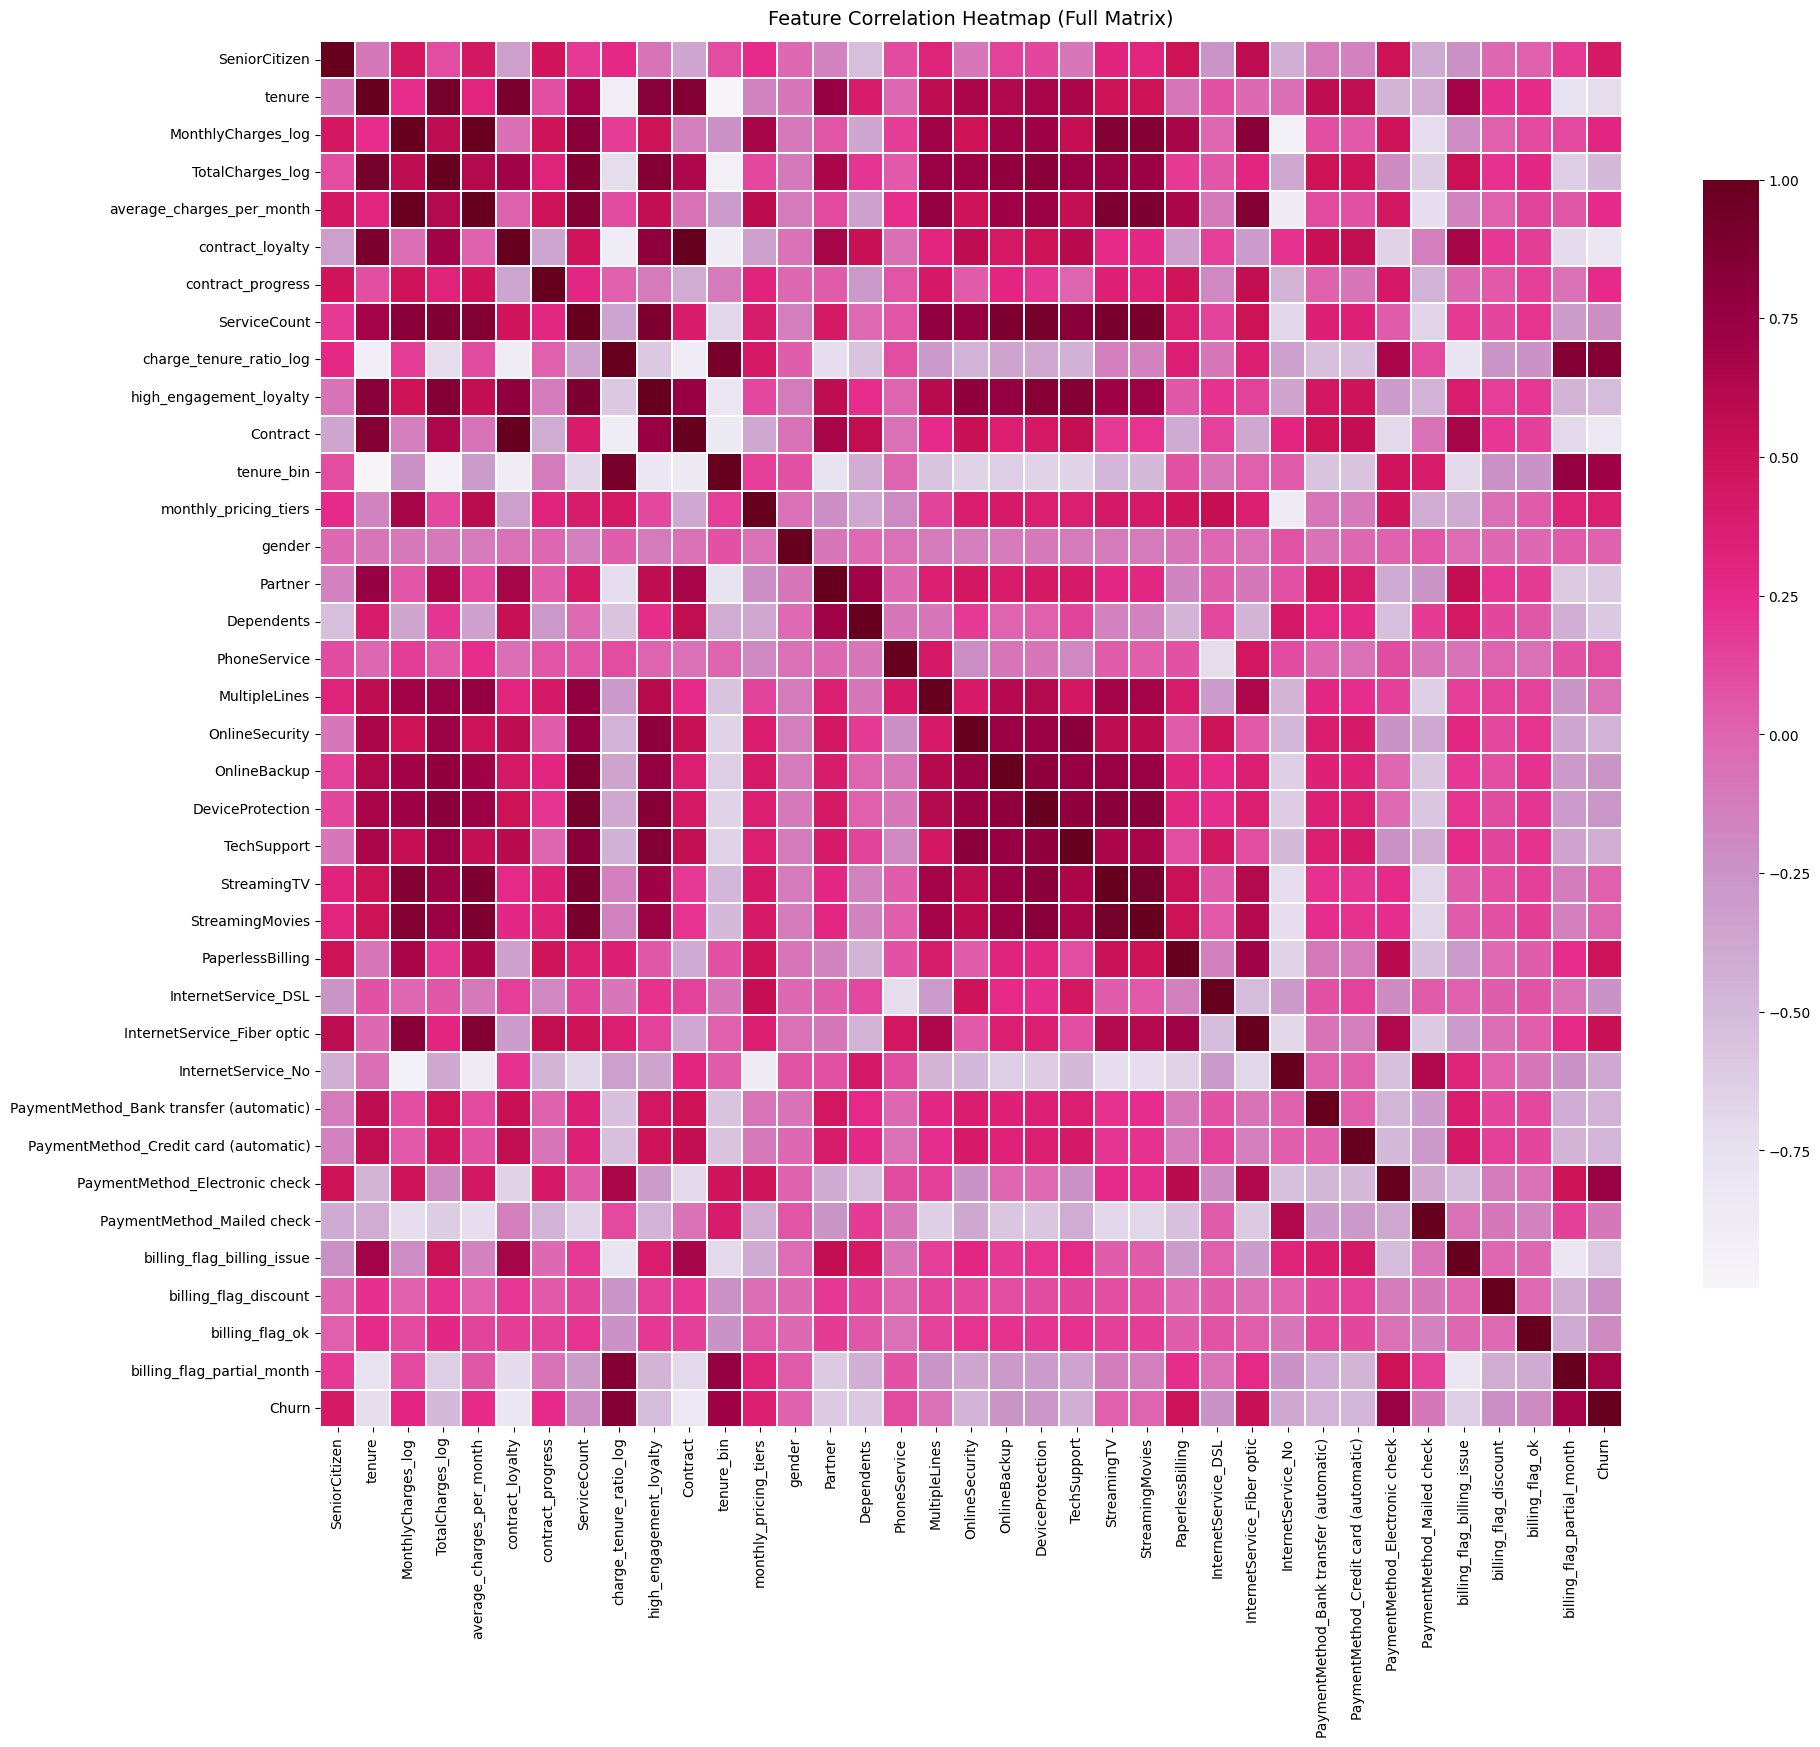

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Combine features + target into one DataFrame
corr_data_tree = X_train_tree.copy()
corr_data_tree["Churn"] = y_train  # replace with your actual target column name

# Compute correlation matrix
corr_matrix_tree = corr_data_tree.corr()

plt.figure(figsize=(21,18))
sns.heatmap(
    corr_matrix_tree.corr(),
    cmap="PuRd",  # magma RdPu PuRd
    center=0,
    annot=False,
    linewidths=0.1,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Heatmap (Full Matrix)", fontsize=14, pad=12)
plt.show()

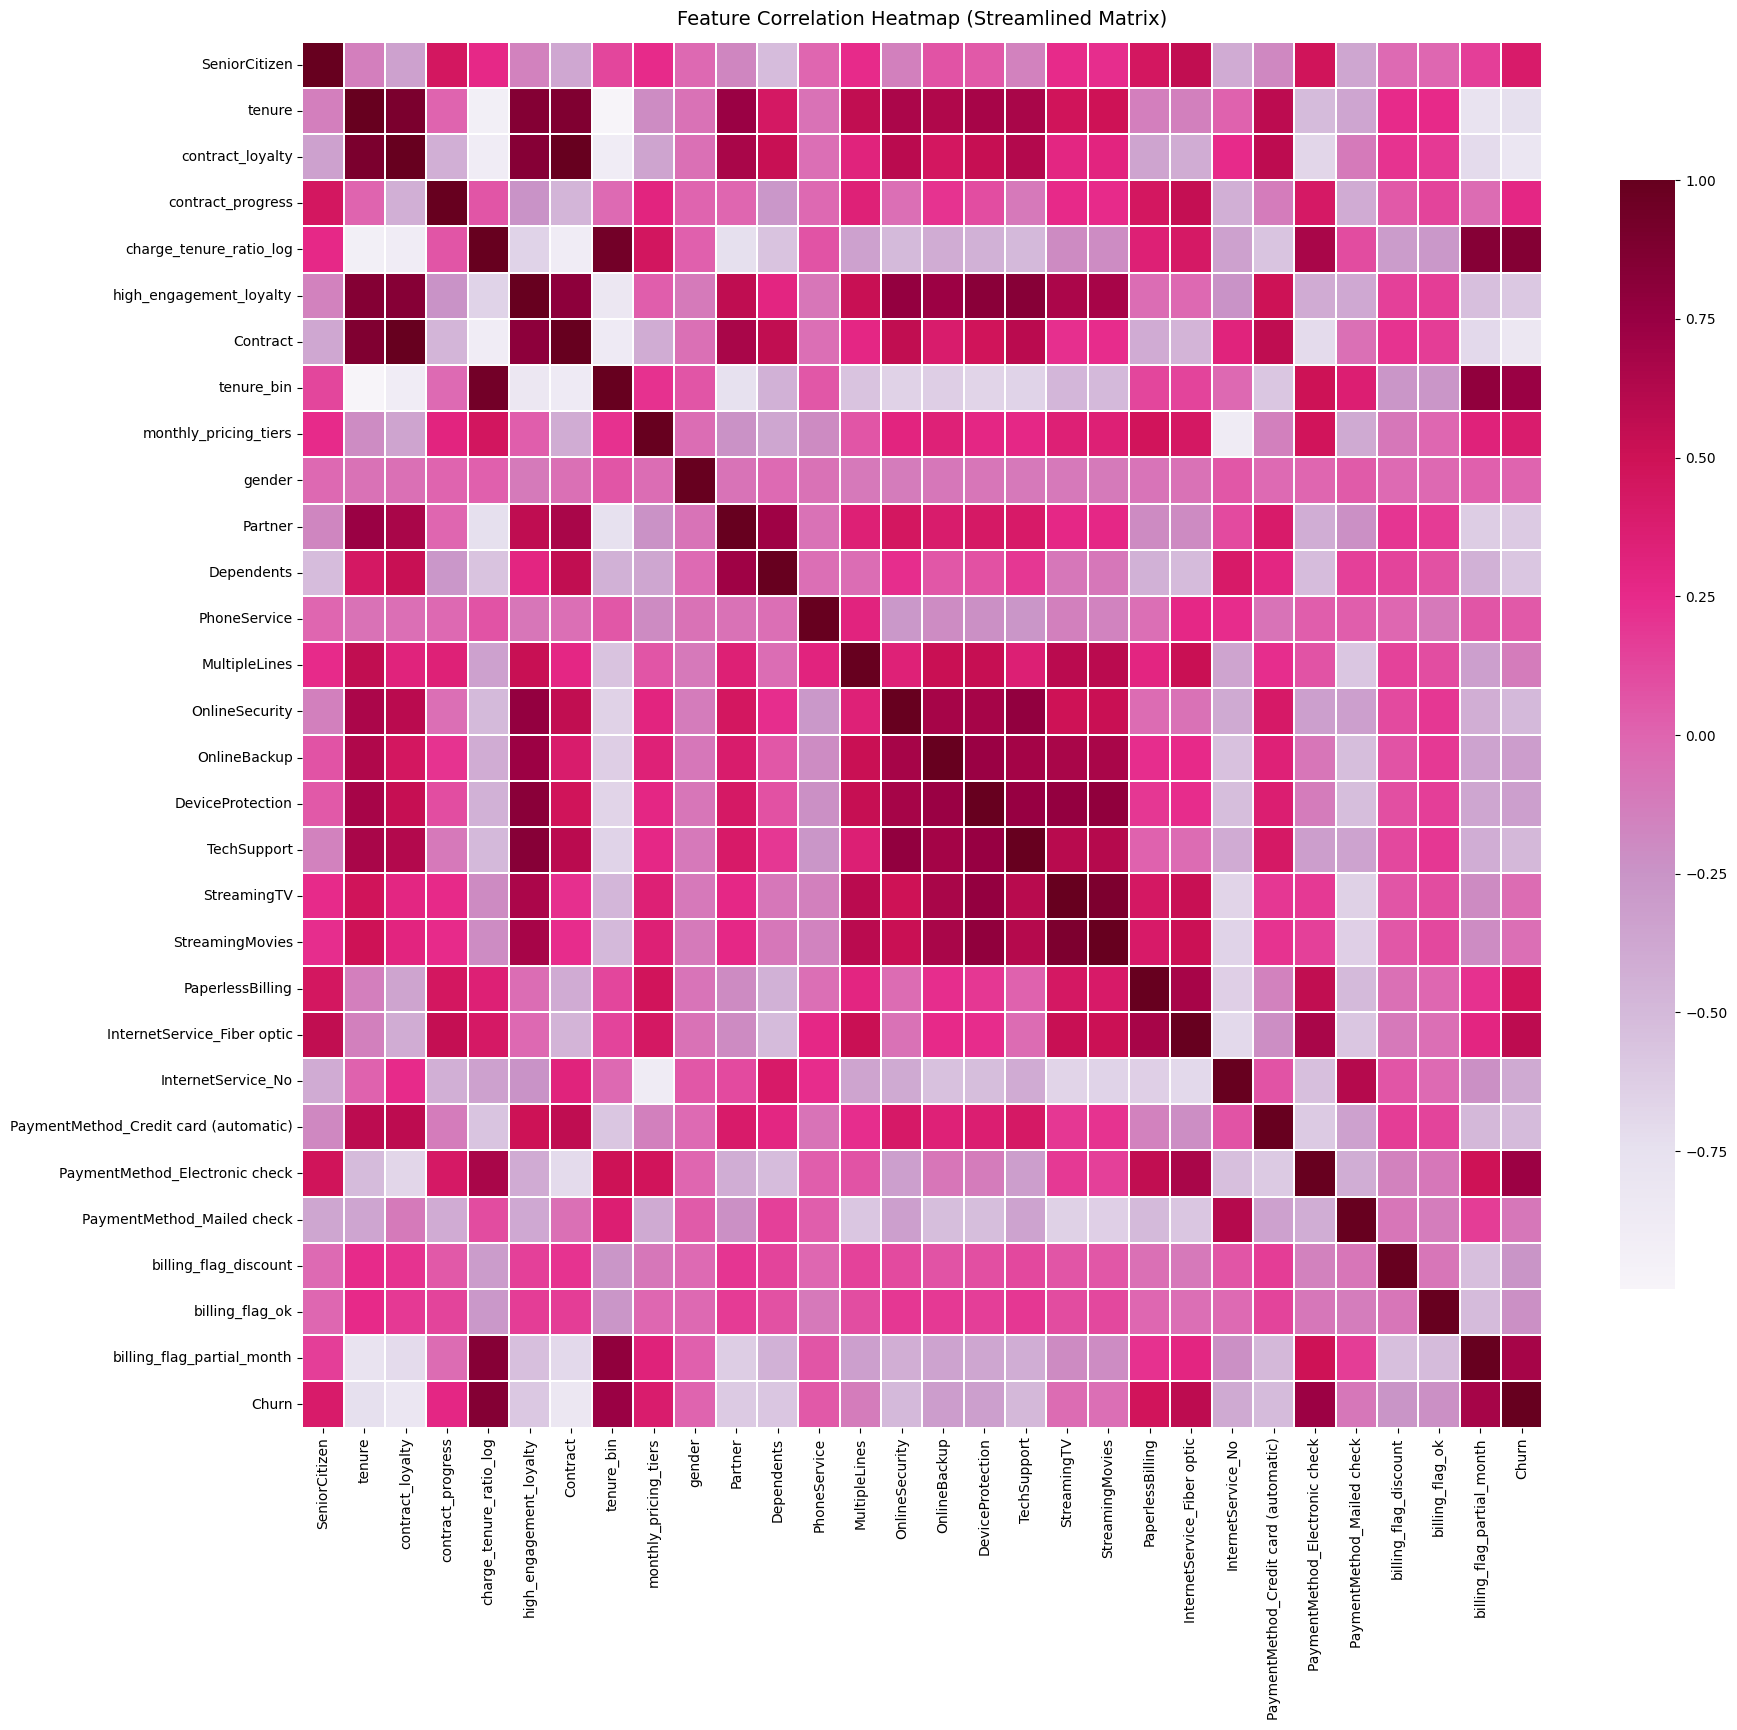

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Combine features + target into one DataFrame
corr_data_linear = X_train_linear.copy()
corr_data_linear["Churn"] = y_train  # replace with your actual target column name

# Compute correlation matrix
corr_matrix_linear = corr_data_linear.corr()

plt.figure(figsize=(20,18))
sns.heatmap(
    corr_matrix_linear.corr(),
    cmap="PuRd",  # magma RdPu PuRd
    center=0,
    annot=False,
    linewidths=0.1,
    cbar_kws={"shrink": .8}
)
plt.title("Feature Correlation Heatmap (Streamlined Matrix)", fontsize=14, pad=12)
plt.show()

In [182]:
# Compute correlataion
# Add target back
Xy_train_tree = X_train_tree.copy()
Xy_train_tree["Churn"] = y_train

# Compute correlation with target
correlations_tree = Xy_train_tree.corr()["Churn"].sort_values(ascending=False).round(2)
print(correlations_tree)


Churn                                      1.00
charge_tenure_ratio_log                    0.48
tenure_bin                                 0.35
InternetService_Fiber optic                0.31
PaymentMethod_Electronic check             0.30
billing_flag_partial_month                 0.25
MonthlyCharges_log                         0.22
average_charges_per_month                  0.20
PaperlessBilling                           0.19
SeniorCitizen                              0.15
monthly_pricing_tiers                      0.13
StreamingTV                                0.07
StreamingMovies                            0.07
contract_progress                          0.07
MultipleLines                              0.05
PhoneService                               0.01
gender                                     0.00
ServiceCount                              -0.06
DeviceProtection                          -0.06
billing_flag_ok                           -0.07
billing_flag_discount                   

In [183]:
# Compute correlataion
# Add target back
Xy_train_linear = X_train_linear.copy()
Xy_train_linear["Churn"] = y_train

# Compute correlation with target
correlations_linear = Xy_train_linear.corr()["Churn"].sort_values(ascending=False).round(2)
print(correlations_linear)


Churn                                    1.00
charge_tenure_ratio_log                  0.48
tenure_bin                               0.35
InternetService_Fiber optic              0.31
PaymentMethod_Electronic check           0.30
billing_flag_partial_month               0.25
PaperlessBilling                         0.19
SeniorCitizen                            0.15
monthly_pricing_tiers                    0.13
StreamingTV                              0.07
StreamingMovies                          0.07
contract_progress                        0.07
MultipleLines                            0.05
PhoneService                             0.01
gender                                   0.00
DeviceProtection                        -0.06
billing_flag_ok                         -0.07
billing_flag_discount                   -0.07
OnlineBackup                            -0.08
PaymentMethod_Mailed check              -0.08
PaymentMethod_Credit card (automatic)   -0.13
Partner                           

### Statistical Tests for Relevance

#### Mutual Information Scores

In [187]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_tree, y_train)
mi_scores = pd.Series(mi_scores, index=X_train_tree.columns).sort_values(ascending=False).round(2)

display(mi_scores)

charge_tenure_ratio_log                    0.13
contract_progress                          0.10
Contract                                   0.09
contract_loyalty                           0.09
tenure                                     0.07
tenure_bin                                 0.06
PaymentMethod_Electronic check             0.06
MonthlyCharges_log                         0.05
InternetService_Fiber optic                0.05
TotalCharges_log                           0.04
average_charges_per_month                  0.04
monthly_pricing_tiers                      0.03
InternetService_No                         0.03
billing_flag_partial_month                 0.03
Dependents                                 0.03
high_engagement_loyalty                    0.02
PaperlessBilling                           0.02
billing_flag_billing_issue                 0.02
ServiceCount                               0.02
OnlineSecurity                             0.02
PaymentMethod_Credit card (automatic)   

In [185]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train_linear, y_train)
mi_scores = pd.Series(mi_scores, index=X_train_linear.columns).sort_values(ascending=False).round(2)

display(mi_scores)

charge_tenure_ratio_log                  0.12
Contract                                 0.10
contract_progress                        0.09
contract_loyalty                         0.08
tenure                                   0.07
tenure_bin                               0.06
InternetService_Fiber optic              0.05
PaymentMethod_Electronic check           0.05
billing_flag_partial_month               0.04
InternetService_No                       0.03
high_engagement_loyalty                  0.03
OnlineSecurity                           0.02
Partner                                  0.02
monthly_pricing_tiers                    0.01
PaperlessBilling                         0.01
billing_flag_discount                    0.01
Dependents                               0.01
PaymentMethod_Mailed check               0.01
MultipleLines                            0.01
TechSupport                              0.01
OnlineBackup                             0.01
billing_flag_ok                   

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2246010814.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores, y=mi_scores.index, palette=mi_scores_palette, edgecolor='black', saturation=1)
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/2246010814.py:5: UserWarning: 
The palette list has fewer values (2) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=mi_scores, y=mi_scores.index, palette=mi_scores_palette, edgecolor='black', saturation=1)


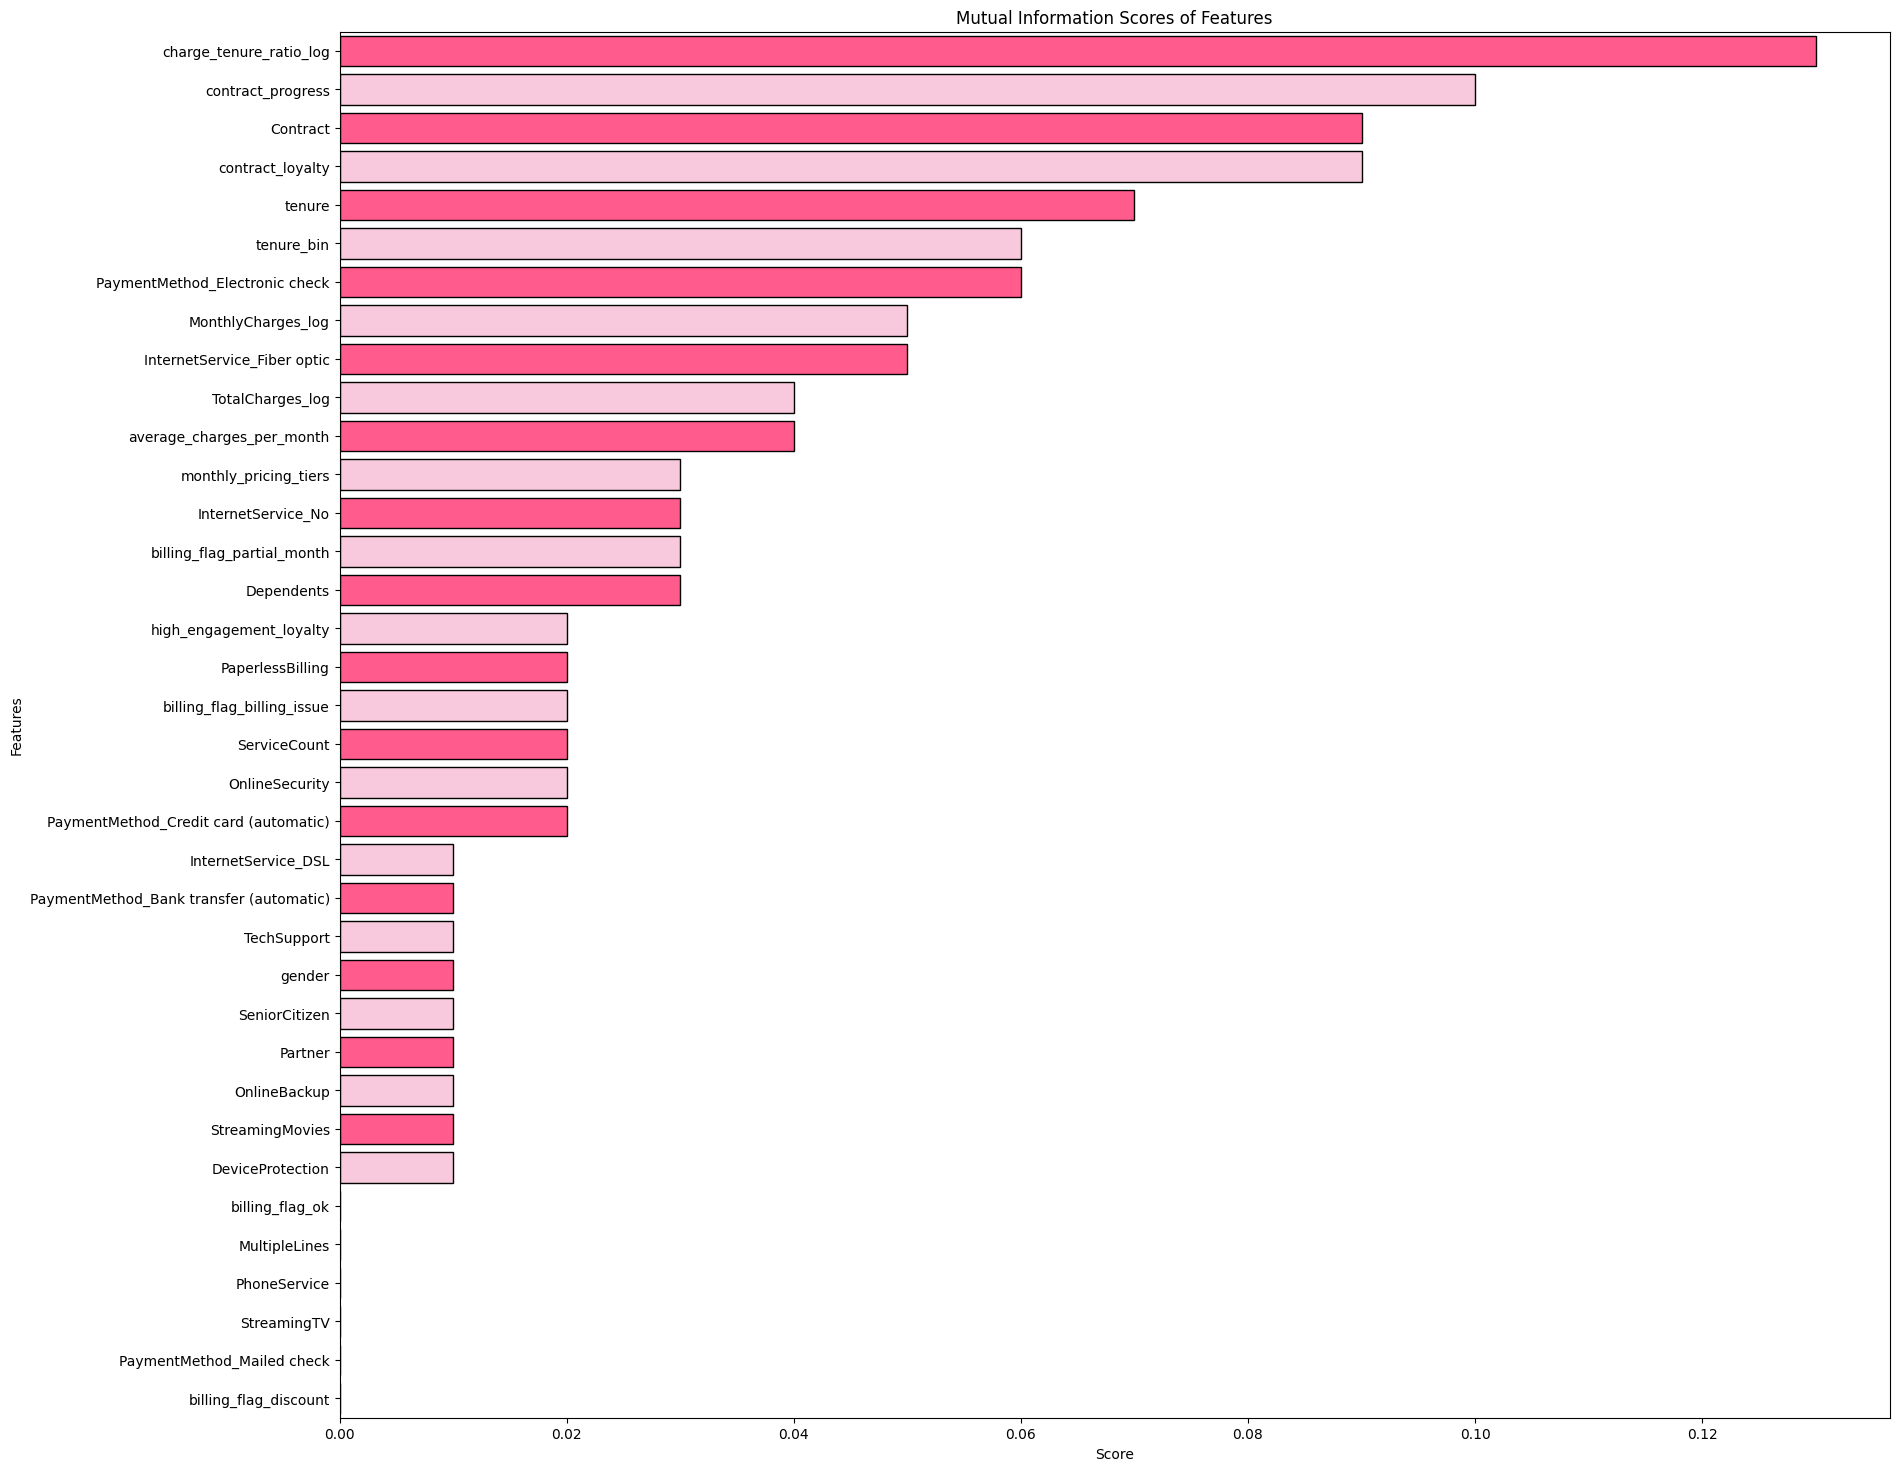

In [189]:
mi_scores_palette = ['#FF5C8D', '#F8C8DC'] 

# Plot with seaborn (palette goes here, not in title)
plt.figure(figsize=(20, 18))
sns.barplot(x=mi_scores, y=mi_scores.index, palette=mi_scores_palette, edgecolor='black', saturation=1)  
plt.title("Mutual Information Scores of Features")
plt.xlabel("Score")
plt.ylabel("Features")
plt.show()

### Model-Based Feature Importance

In [91]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tree, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train_tree.columns)
importances.sort_values(ascending=False).round(2)

charge_tenure_ratio_log                    0.11
average_charges_per_month                  0.08
MonthlyCharges_log                         0.08
TotalCharges_log                           0.08
spend_per_service                          0.07
tenure                                     0.07
contract_progress                          0.06
Contract                                   0.04
contract_paperless_Month-to-month_Yes      0.04
InternetService_Fiber optic                0.03
tenure_bin                                 0.02
security_bundle                            0.02
PaymentMethod_Electronic check             0.02
ServiceCount                               0.02
gender                                     0.02
Partner                                    0.01
contract_loyalty                           0.01
billing_flag_partial_month                 0.01
Dependents                                 0.01
OnlineSecurity                             0.01
streaming_bundle                        

/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/249019620.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette=importances_palette, edgecolor='black', saturation=1)
/var/folders/6v/w8nfkj8x66xc_mdtqnhljxq40000gn/T/ipykernel_6064/249019620.py:4: UserWarning: 
The palette list has fewer values (2) than needed (47) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=importances, y=importances.index, palette=importances_palette, edgecolor='black', saturation=1)


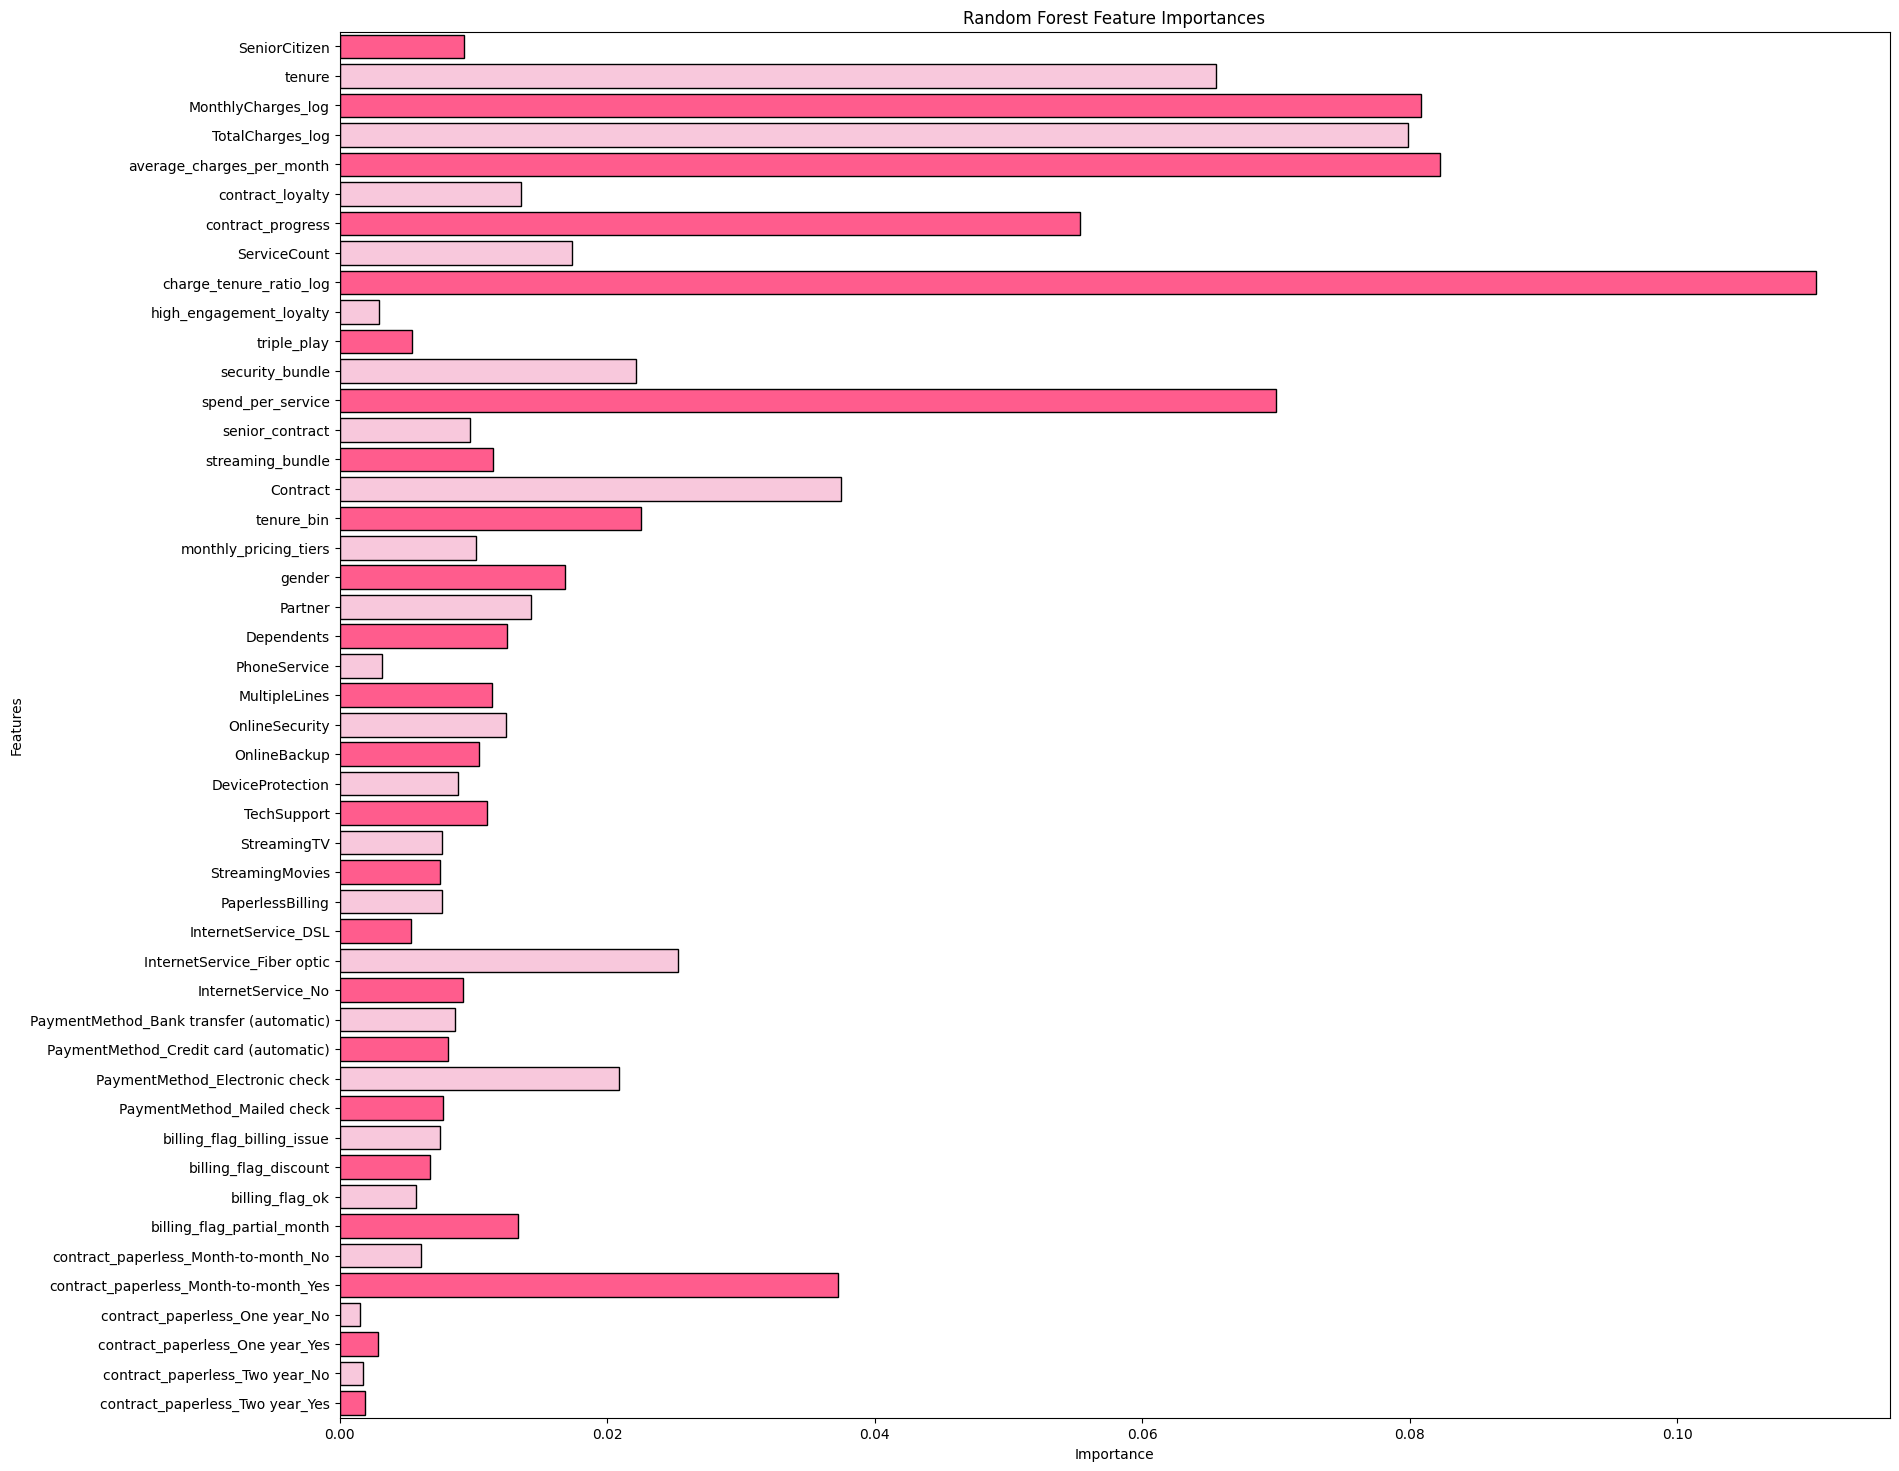

In [92]:
importances_palette = ['#FF5C8D', '#F8C8DC'] 

plt.figure(figsize=(20, 18))
sns.barplot(x=importances, y=importances.index, palette=importances_palette, edgecolor='black', saturation=1)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [93]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_linear, y_train)

importances = pd.Series(rf.feature_importances_, index=X_train_linear.columns)
importances.sort_values(ascending=False).round(2)

charge_tenure_ratio_log                  0.16
spend_per_service                        0.13
tenure                                   0.10
contract_progress                        0.08
Contract                                 0.05
InternetService_Fiber optic              0.04
PaymentMethod_Electronic check           0.03
contract_loyalty                         0.03
gender                                   0.03
monthly_pricing_tiers                    0.03
PaperlessBilling                         0.02
tenure_bin                               0.02
Partner                                  0.02
billing_flag_partial_month               0.02
OnlineSecurity                           0.02
OnlineBackup                             0.02
Dependents                               0.02
MultipleLines                            0.02
TechSupport                              0.02
DeviceProtection                         0.02
StreamingMovies                          0.01
senior_contract                   

##### Observation:

##### Top correlated features with Churn
These features have the strongest positive correlation with churn. The customers with higher values here are more likely to chrun
| Feature                       | Correlation with Churn |
| ----------------------------- | ---------------------- |
| `charge_tenure_ratio_log`     | **+0.475**             |
| `Contract_Month-to-month`     | **+0.405**             |
| `tenure_bin_Short term`       | **+0.320**             |
| `InternetService_Fiber optic` | **+0.307**             |
| `MonthlyCharges_log`          | **+0.210**             |


- Customers on month-to-month plans,
- With short tenure,
- Using fiber optip internet,
- and paying higher charges are more likely to churn

#### Negatively Correlated Features
These features reduce the likelihood of churn.
| Feature             | Correlation |
| ------------------- | ----------- |
| `contract_length`   | **-0.394**  |
| `contract_loyalty`  | **-0.384**  |
| `tenure`            | **-0.354**  |
| `Contract_Two year` | **-0.302**  |
| `TotalCharges_log`  | **-0.242**  |

-Customers with longer tenure and longer contracts tend to stay.

##### What to Do With This
1. Feature Selection: Focus on top correlated features (±0.2 and above) when training your model.
2. Model Insight: Use this to explain why your model makes certain predictions.
3. Business Action: For churn reduction:

    - Encourage longer contracts.
    - Target short-tenure, fiber users for retention.



##### 1.4.1.2. Dropping low-correalation features

To help reduce overfitting and improve model performance

In [ ]:
# # Filter features based on a correlation threshold

# threshold = 0.1
# selected_features = correlations[abs(correlations) >= threshold].index.tolist()


# if 'Churn' in selected_features:
#     selected_features.remove('Churn')

# selected_features

# # Store selected features in a new feature matrix
# X_selected = X_encoded[selected_features]

In [94]:
remove_for_trees = ['tenure_bin', 'gender', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'DeviceProtection',
                    'OnlineBackup', 'MultipleLines', 'PaymentMethod_Mailed check',
                    'PaymentMethod_Credit card (automatic)', 'InternetService_DSL']

remove_for_linear = ['tenure', 'contract_progress', 'gender', 'PhoneService', 'StreamingTV', 'StreamingMovies', 'DeviceProtection',
                    'OnlineBackup', 'MultipleLines', 'PaymentMethod_Mailed check',
                    'PaymentMethod_Credit card (automatic)']


X_train_tree = X_train_tree.drop(columns=remove_for_trees)
X_train_linear = X_train_linear.drop(columns=remove_for_linear)

In [95]:
# For tree-based model
selected_tree_features = X_train_tree.columns  # <-- just the column names
X_test_tree = X_test_tree[selected_tree_features]

# For linear model
selected_linear_features = X_train_linear.columns
X_test_linear = X_test_linear[selected_linear_features]


In [96]:
X_test_tree = X_test_tree[selected_tree_features]
X_test_linear = X_test_linear[selected_linear_features]

In [97]:
print(calculate_vif(X_train_linear))

                           feature       VIF
0                    SeniorCitizen  2.053356
1                 contract_loyalty  9.639873
2          charge_tenure_ratio_log  4.020463
3          high_engagement_loyalty  3.504723
4                      triple_play  3.561212
5                spend_per_service  7.831008
6                  senior_contract  1.776052
7                         Contract  8.761740
8                       tenure_bin  9.987766
9            monthly_pricing_tiers  5.523626
10                         Partner  2.757998
11                      Dependents  1.959683
12                  OnlineSecurity  1.997667
13                     TechSupport  2.133453
14                PaperlessBilling  2.820741
15     InternetService_Fiber optic  3.123723
16              InternetService_No  5.126852
17  PaymentMethod_Electronic check  1.930028
18           billing_flag_discount  1.462701
19                 billing_flag_ok  1.441020
20      billing_flag_partial_month  3.686162


In [98]:
print("Shape for X_train_linear:", X_train_linear.shape)
print("Shape for X_test_linear:", X_test_linear.shape)

print("Shape for X_train_tree:", X_train_tree.shape)
print("Shape for X_test_tree:", X_test_tree.shape)


Shape for X_train_linear: (4922, 21)
Shape for X_test_linear: (2110, 21)
Shape for X_train_tree: (4922, 36)
Shape for X_test_tree: (2110, 36)


High correlations (|r| > 0.8 or 0.9) between features may indicate multicollinearity, which can hurt linear models like logistic regression.

- TotalCharges_log and EstimatedTotalCharges_log have near-perfect correlation.
- contract_loyalty, contract_length, and Contract_Two year also show high correlation.
- tenure and tenure_bin_Long term are closely correlated.


##### 1.4.1.3.1.  Solution #1: Dropping one dummy per categorical variable

Dropping the most common category

- To help the model compare everything to the "usual" case. This makes the model interpret other categories in relation to the most common one.

##### Finding the most common category in each column

##### Replacing the most common category with NaN(so that it is ignored by get_dummies)

In [99]:
# Save feature names
import joblib

joblib.dump(X_train_tree.columns.tolist(), '/Users/eseoseodion/Documents/Portfolio/Customer Churn Prediction/saved_data/feature_names/tree_feature_names.pkl')
joblib.dump(X_train_linear.columns.tolist(), '/Users/eseoseodion/Documents/Portfolio/Customer Churn Prediction/saved_data/feature_names/linear_feature_names.pkl')

['/Users/eseoseodion/Documents/Portfolio/Customer Churn Prediction/saved_data/feature_names/linear_feature_names.pkl']

In [100]:
# Convert to a numpy array 
X_train_tree = X_train_tree.values 
X_train_linear = X_train_linear.values 

### 1.6. Using the SMOTE (Synthetic Minority Oversampling Technique) To handle imbalanced classes

In [101]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled_tree, y_train_resampled_tree = smote.fit_resample(X_train_tree, y_train)
X_train_resampled_linear, y_train_resampled_linear = smote.fit_resample(X_train_linear, y_train)

In [ ]:
# from imblearn.combine import SMOTEENN

# smoteenn = SMOTEENN(random_state=42)
# X_train_resampled_tree, y_train_resampled_tree = smoteenn.fit_resample(X_train_tree, y_train)
# X_train_resampled_linear, y_train_resampled_linear = smoteenn.fit_resample(X_train_linear, y_train)

In [ ]:
# from imblearn.over_sampling import ADASYN

# # adasyn = ADASYN(random_state=0)
# adasyn = ADASYN(random_state=42)

# X_train_resampled_tree, y_train_resampled_tree = adasyn.fit_resample(X_train_tree, y_train)
# X_train_resampled_linear, y_train_resampled_linear = adasyn.fit_resample(X_train_linear, y_train)

In [ ]:
# from imblearn.combine import SMOTETomek

# smt = SMOTETomek(random_state=42)
# X_train_resampled_tree, y_train_resampled_tree = smt.fit_resample(X_train_tree, y_train)
# X_train_resampled_linear, y_train_resampled_linear = smt.fit_resample(X_train_linear, y_train)

This is a mild to moderate imbalance (not extreme like 95:5), so both oversampling and undersampling are viable options — but each has trade-offs.


Your dataset is not huge → oversampling won’t be too slow
Minority class is still decently sized (1869) → SMOTE can create diverse synthetic samples
Undersampling would discard too much useful data (removing from 5174 to ~1869)

Why I Didn't Use Undersampling (alone)?

The dataset is mild to moderately imbalanced for the target variable, so both oversampling and undersampling would've been viable options. However, there was a high likelihood that a lot of the the majority class would've been thrown away, which would've have created a risk of underfitting and poor generalization.


##### From EDA
During evaluation, use metrics that handle the imbalance; use precision, recall, f1-score, auc-roc, and confusion matrices. Avoid only using accuracy

Consider implementing ensemble methods like RandomForest or XGBoost; these perform better on imbalanced datasets.

Possibly use other models or algorithms that handle imbalance better (like class_weight='balanced' in logistic regression, decision trees, etc.).



In [102]:
# Optional: Check class distribution after resampling

from collections import Counter
print(Counter(y_train_resampled_tree))
print(Counter(y_train_resampled_linear))

Counter({np.int64(1): 3614, np.int64(0): 3614})
Counter({np.int64(1): 3614, np.int64(0): 3614})


In [103]:
import joblib

# Save train-test data
joblib.dump(X_train_resampled_tree, '../saved_data/train_test_data/X_train_tree.pkl')
joblib.dump(X_train_resampled_linear, '../saved_data/train_test_data/X_train_linear.pkl')

joblib.dump(X_test_tree, '../saved_data/train_test_data/X_test_tree.pkl')
joblib.dump(X_test_linear, '../saved_data/train_test_data/X_test_linear.pkl')

joblib.dump(y_train_resampled_tree, '../saved_data/train_test_data/y_train_tree.pkl')
joblib.dump(y_train_resampled_linear, '../saved_data/train_test_data/y_train_linear.pkl')

joblib.dump(y_test, '../saved_data/train_test_data/y_test.pkl')


['../saved_data/train_test_data/y_test.pkl']

In [104]:
# Save original copies

X_train_tree_original = X_train_resampled_tree.copy()
X_train_linear_original = X_train_resampled_linear.copy()

X_test_tree_original = X_test_tree.copy()
X_test_linear_original = X_test_linear.copy()

y_train_tree_original = y_train_resampled_tree.copy()
y_train_linear_original = y_train_resampled_linear.copy()

y_test_original = y_test.copy()


### 1.7. Feature Scaling

- No need to scale the matrix for the tree based models but the linear models matrix of features will be scaled for the 'charge_tenure_ratio_log'

In [105]:
# Reset before new model

X_train_tree = X_train_tree_original.copy()
X_train_linear = X_train_linear_original.copy()

X_test_tree = X_test_tree_original.copy()
X_test_linear = X_test_linear_original.copy()

y_train_tree = y_train_tree_original.copy()
y_train_linear = y_train_linear_original.copy()

y_test = y_test_original.copy()


In [ ]:
import joblib

# --- Save scaled data ---
# joblib.dump(scaler, '../saved_data/scaler/scaler.pkl')  # in modelling.ipynb

## 2. Modelling

Preserving the original data when testing the multiple models so that data leakage, transformation effects, or accidental mutations don’t interfere with the comparisons.

Before training a new model, reset working variables:

#### 2.1. Building A Reusable Pipeline

In [106]:
# --- Imports ---
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# --- instantiate the models ---
lr_classifier = LogisticRegression(random_state=42)
svc_classifier = SVC(kernel="linear", C=1, random_state=42)
dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
xgb_classifier = XGBClassifier(random_state=42, n_jobs=-1)
lgb_classifier = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
cat_classifier = CatBoostClassifier(random_seed=42, verbose=0)


# lr_classifier = LogisticRegression(random_state=42,  C=1.0, solver='lbfgs', max_iter=1000)

# svc_classifier = SVC(kernel="linear", C=1, random_state=42)

# dt_classifier = DecisionTreeClassifier(max_depth=5, min_samples_split=10, 
#                                        min_samples_leaf=5, criterion='entropy', random_state=42)

# rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, 
#                                        min_samples_leaf=5, criterion='entropy', random_state=42)

# xgb_classifier = XGBClassifier(random_state=42, n_jobs=-1, n_estimators=300, 
#                                max_depth=6, learning_rate=0.1, reg_alpha=0.1, reg_lambda=1.0)

# lgb_classifier = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, num_leaves=31, random_state=42)

# cat_classifier = CatBoostClassifier(random_seed=42, iterations=300, depth=6, learning_rate=0.1, verbose=0)

# models = [lr_classifier, svc_classifier, dt_classifier, rf_classifier, xgb_classifier, lgb_classifier, cat_classifier]

# --- Store models in a dict ---

models = {
    "linear models": [lr_classifier, svc_classifier],
    "tree models": [dt_classifier, rf_classifier, xgb_classifier, lgb_classifier, cat_classifier]
}

for family, model_list in models.items():
    for model in model_list: # iterate through each model in the list
        try:
            # Reset the data
            X_train_tree = X_train_tree_original.copy()
            X_train_linear = X_train_linear_original.copy()
            X_test_tree = X_test_tree_original.copy()
            X_test_linear = X_test_linear_original.copy()
            y_train_tree = y_train_tree_original.copy()
            y_train_linear = y_train_linear_original.copy()
            y_test = y_test_original.copy()

            if family == "linear models":  
                model.fit(X_train_linear, y_train_linear)
            else:
                model.fit(X_train_tree, y_train_tree)
            
            #joblib.dump(model, f'{model.__class__.__name__}.pkl')

            # Save model
            model_name = model.__class__.__name__
            save_path = f'../saved_models/{model_name}.pkl'
            joblib.dump(model, save_path)
            print(f"✅ Saved {model_name} successfully at {save_path}")

        except Exception as e:
            print(f"Failed to train {model.__class__.__name__}: {e}")

✅ Saved LogisticRegression successfully at ../saved_models/LogisticRegression.pkl
✅ Saved SVC successfully at ../saved_models/SVC.pkl
✅ Saved DecisionTreeClassifier successfully at ../saved_models/DecisionTreeClassifier.pkl
✅ Saved RandomForestClassifier successfully at ../saved_models/RandomForestClassifier.pkl
✅ Saved XGBClassifier successfully at ../saved_models/XGBClassifier.pkl
[LightGBM] [Info] Number of positive: 3614, number of negative: 3614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6870
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt